# **Proyecto de Predicción de Fuga de Clientes (Churn): Interconnect**

## **1. Contexto de Negocio**

El operador de telecomunicaciones **Interconnect** busca fortalecer su estrategia de retención de clientes. La pérdida de suscriptores (Churn) representa uno de los mayores desafíos financieros en la industria. Para mitigar este impacto, el departamento de marketing requiere un sistema predictivo que identifique a los usuarios con mayor probabilidad de abandonar el servicio para ofrecerles incentivos personalizados de forma proactiva.

## **2. Objetivo Técnico**

El propósito de este proyecto es desarrollar un modelo de Machine Learning capaz de pronosticar la fuga de clientes utilizando datos demográficos, información de contratos y servicios contratados.

* **Métrica Principal:** Se busca alcanzar un valor de **$AUC−ROC>0.88$**.
* **Métrica Secundaria:** Optimización del **Recall** para maximizar la captura de desertores potenciales.

## **3. Hoja de Ruta (Roadmap)**

Para alcanzar el objetivo, se ha diseñado un plan de trabajo dividido en cuatro fases críticas:

### **Fase 1: Ingeniería de Datos y Preprocesamiento**

* Consolidación de múltiples fuentes de datos mediante un esquema de *Left Join*.
* Tratamiento forense de valores nulos y creación de la variable de magnitud **`Tenure`** (antigüedad).
* Limpieza de inconsistencias en registros financieros (`TotalCharges`).

### **Fase 2: Estrategia de Codificación y Escalado**

* División estratificada del dataset (80/20) para preservar el desbalance de clases (26.5%).
* Implementación de pipelines de transformación diferenciados: **One-Hot Encoding** para modelos lineales y **Native/Ordinal Encoding** para modelos de ensamble.
* Normalización de variables numéricas para garantizar la estabilidad de los gradientes.

### **Fase 3: Modelado y Optimización de Hiperparámetros**

* Evaluación comparativa de cuatro arquitecturas: **Logistic Regression**, **Random Forest**, **CatBoost** y **LightGBM**.
* Búsqueda sistemática de parámetros mediante *GridSearchCV* y *RandomizedSearchCV* para maximizar la señal predictiva.

### **Fase 4: Evaluación y Diagnóstico de Negocio**

* Implementación de una herramienta de diagnóstico de **6 paneles** (Curvas ROC/PRC, Calibración, Importancia de Variables y Matriz de Confusión).
* Ajuste fino de umbrales (*Threshold Tuning*) para alinear el modelo con los objetivos de costo-beneficio del área de marketing.

---

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import time
import os

# Librerías gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías ML
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Librerías de modelos de ML
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.calibration import calibration_curve

## **SECCIÓN 1:** - *EDA*

In [2]:
# Definimos la ruta de la carpeta de datos
DATA_PATH = os.path.join('..', 'data')

df_contract = pd.read_csv(os.path.join(DATA_PATH, 'contract.csv'))
df_personal = pd.read_csv(os.path.join(DATA_PATH, 'personal.csv'))
df_internet = pd.read_csv(os.path.join(DATA_PATH, 'internet.csv'))
df_phone = pd.read_csv(os.path.join(DATA_PATH, 'phone.csv'))

In [3]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
df_contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2569,8237-ULIXL,2014-02-01,No,Two year,No,Credit card (automatic),24.85,1871.85
5851,4118-CEVPF,2017-03-01,No,One year,Yes,Bank transfer (automatic),110.80,3836.3
5545,7658-UYUQS,2018-05-01,No,Month-to-month,No,Bank transfer (automatic),86.55,1857.25
1014,4695-VADHF,2018-07-01,2020-01-01 00:00:00,Month-to-month,No,Electronic check,57.45,990.85
373,2805-EDJPQ,2015-06-01,No,One year,Yes,Credit card (automatic),99.75,5608.4


In [5]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [6]:
df_personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
1923,7696-CFTAT,Male,0,Yes,Yes
3005,0516-QREYC,Female,1,No,No
3083,1599-EAHXY,Male,0,Yes,Yes
6382,8608-OZTLB,Male,0,Yes,Yes
7018,1122-JWTJW,Male,0,Yes,Yes


In [7]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [8]:
df_internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1901,7548-SEPYI,Fiber optic,No,Yes,No,No,Yes,Yes
2073,6769-DCQLI,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
4249,2455-USLMV,Fiber optic,Yes,No,Yes,No,No,No
663,3104-OWCGK,Fiber optic,No,Yes,Yes,No,Yes,No
5091,6166-YIPFO,DSL,Yes,Yes,Yes,Yes,Yes,Yes


In [9]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [10]:
df_phone.sample(5)

,customerID,MultipleLines
929,7147-AYBAA,No
1070,0125-LZQXK,No
2616,7517-LDMPS,No
5118,5393-RXQSZ,No
5341,2138-VFAPZ,No


**Comentarios:**

Al realizarse la primera aproximación a los datos, a partir de su estructura, podemos destacar ciertos aspectos.

- **Observación:** `df_contract` y `df_personal` tienen 7,043 registros, pero `df_internet` tiene 5,517 y `df_phone` tiene 6,361.
    - Esto confirma que no todos los clientes tienen todos los servicios. Hay personas que solo tienen teléfono, otras solo internet, y otras ambos.
    - Como se comentaba al inicio, al unir las tablas, aparecerán valores nulos (NaN). No son errores, sino "ausencias de servicio" que deberemos gestionar.

- **Inconsistencias en los tipos de datos:**
    - La columna `TotalCharges` se encuentra como `object` en `df_contract`, esta columna debería ser numérica pero actualmente se muestra como texto.
    - Las fechas `BeginDate` y `EndDate` son texto.

- **Deducción de la variable objetivo `Churn`:**
    - Deberemos crearla a partir de una condición simple, si hay `EndDate` el cliente ha cancelado el servicio en algún punto (1), caso contrario, el cliente se mantiene activo (0).
 
---

### **1.1 EDA: Data Profiling**

Para este paso, requerimos una estrategia de unificación tipo **Left Join**, ya que queremos mantener a los 7,043 clientes de la tabla principal (`contract`) y traer la información de las otras tablas.

In [11]:
df_complete = (
    df_contract
    .merge(df_personal, on='customerID', how='left')
    .merge(df_internet, on='customerID', how='left')
    .merge(df_phone, on='customerID', how='left')
)

In [12]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [13]:
df_complete.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2539,2050-ONYDQ,2014-09-01,No,Two year,No,Credit card (automatic),26.00,1654.85,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2684,5440-VHLUL,2014-05-01,No,One year,Yes,Bank transfer (automatic),105.20,7386.05,Male,0,No,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Yes
6554,2856-HYAPG,2019-10-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,68.65,68.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
6904,6211-WHMYA,2014-10-01,No,Month-to-month,Yes,Electronic check,43.85,2751,Female,1,No,No,DSL,No,Yes,No,Yes,Yes,No,NaN
4247,5161-UBZXI,2014-05-01,No,Two year,Yes,Credit card (automatic),106.35,7261.75,Male,0,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,No


### **1.2 EDA: Sanity Check**

Debemos transformar las columnas `BeginDate`, `EndDate` y `TotalCharges` de object a date y float según la necesidad tomando en cuenta algunas consideraciones:

1. Convertir `BeginDate` a formato fecha:
    - Usarla como base para crear una variable derivada más informativa.
 
2. Columna `EndDate` y conversión a formato fecha: Aquí hay una mezcla de "No" (clientes activos) y fechas (clientes que se fueron).
    - Para calcular la antigüedad (Tenure), necesitamos una fecha final para todos, establecida como 1 de febrero de 2020.
        - *Si el cliente no se ha ido (`EndDate == 'No'`), su "fecha final" para el cálculo será la fecha de corte del dataset: 1 de febrero de 2020.*

> **NOTA:** De este primer proceso de sanitización de los datos obtenermos `Tenure` y `Churn`.

3. Para la columna `TotalCharges` que actualmente es de tipo `object` realizar la conversión a float, tomar en cuenta que:
    - Generalmente, los clientes que acaban de contratar el servicio tienen 0 días de antigüedad y su TotalCharges está vacío (un espacio en blanco " "). Ese simple espacio obliga a Pandas a tratar toda la columna como texto.
    - Usaremos `pd.to_numeric()` con el parámetro `errors='coerce'` para que si encuentra un espacio en blanco, lo convierta en NaN (nulo) en lugar de lanzar un error.

4. Tratamiento de `NaN's`: este paso es importante ya que posterior al Left Join encontramos muchos `NaN's` lo cuales, en modelos de clasificación sigieren un vacío de información que el algoritmo no sabe interpretar.
    - Los `NaN's` sugen de servicios que el cliente no ha contratado, por lo tanto, no son errores, pero debemos actualizar su valor.

#### **1.2.1 Convertir BeginDate a formato fecha** `.pd.to_datetime()`

In [14]:
# Convirtiendo BeginDate a fecha

df_complete['BeginDate'] =  pd.to_datetime(df_complete['BeginDate'], format='%Y-%m-%d')

#### **1.2.2 Convertir EndDate a formato fecha y creación de Churn** `.pd.to_datetime()`

In [15]:
# Creación de la columna churn

df_complete['Churn'] = np.where(df_complete['EndDate'] != 'No', 1, 0)

In [16]:
# Reemplazando los valores 'No' en EndDate por la fecha de corte establecida en 1 de febrero

print(df_complete['EndDate'].value_counts())

df_complete['EndDate'] = df_complete['EndDate'].replace('No', '2020-02-01 00:00:00')

EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64


In [17]:
print(df_complete['EndDate'].value_counts())

EndDate
2020-02-01 00:00:00    5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64


In [18]:
df_complete['EndDate'] = pd.to_datetime(df_complete['EndDate'], format='%Y-%m-%d %H:%M:%S')

In [19]:
# Creación de Tenure

df_complete['Tenure'] = (df_complete['EndDate'] - df_complete['BeginDate']).dt.days

#### **1.2.3 TotalCharges a Float** `pd.to_numeric()`

In [20]:
# Convirtiendo 'TotalCharges' a float
df_complete['TotalCharges'] = pd.to_numeric(
    df_complete['TotalCharges'],
    errors='coerce'
)

In [21]:
print(df_complete.sample(5))

      customerID  BeginDate    EndDate            Type PaperlessBilling  \
6379  0940-OUQEC 2019-02-01 2019-12-01  Month-to-month              Yes   
1863  9575-IWCAZ 2019-08-01 2020-02-01        One year               No   
4859  8041-TMEID 2014-11-01 2020-02-01        Two year               No   
2575  5186-PEIZU 2017-03-01 2020-02-01  Month-to-month               No   
2351  9755-JHNMN 2016-01-01 2020-02-01        Two year               No   

                  PaymentMethod  MonthlyCharges  TotalCharges  gender  \
6379  Bank transfer (automatic)           80.70        788.80    Male   
1863               Mailed check           25.10        171.00    Male   
4859    Credit card (automatic)          108.50       6991.90    Male   
2575  Bank transfer (automatic)           19.25        617.65  Female   
2351  Bank transfer (automatic)           67.40       3306.85  Female   

      SeniorCitizen  ... InternetService OnlineSecurity OnlineBackup  \
6379              0  ...     Fiber opt

#### **1.2.4 Búsqueda de duplicados** `.duplicated()`

In [22]:
# Lista de DataFrames originales
original_dfs = {
    'Contract': df_contract,
    'Personal': df_personal,
    'Internet': df_internet,
    'Phone': df_phone
}

for name, df_orig in original_dfs.items():
    print(f"--- Búsqueda en: {name} ---")
    
    # 1. Filas exactamente iguales
    exact_dups = df_orig.duplicated().sum()
    
    # 2. Clientes repetidos (ID duplicado)
    id_dups = df_orig['customerID'].duplicated().sum()
    
    print(f"  --> Filas idénticas: {exact_dups}")
    print(f"  --> customerID repetidos: {id_dups}")
    print("-" * 30)


--- Búsqueda en: Contract ---
  --> Filas idénticas: 0
  --> customerID repetidos: 0
------------------------------
--- Búsqueda en: Personal ---
  --> Filas idénticas: 0
  --> customerID repetidos: 0
------------------------------
--- Búsqueda en: Internet ---
  --> Filas idénticas: 0
  --> customerID repetidos: 0
------------------------------
--- Búsqueda en: Phone ---
  --> Filas idénticas: 0
  --> customerID repetidos: 0
------------------------------


**Comentarios:**

- Se han documentado 0 registros duplicados (filas y `customerID`) para nuestras fuentes primarias, estas dan origen a nuestro `df_complete`, por lo tanto, se confirma una cardinalidad 1:1 estricta entre las tablas de contrato, servicios y datos personales".

In [23]:
# Análisis de duplicados en el dataframe unido

dups = df_complete.duplicated().sum()
print('Existen', dups, 'filas duplicadas en el Dataset')

Existen 0 filas duplicadas en el Dataset


In [24]:
print('Existen', df_complete.duplicated(subset=['customerID']).sum(), 'clientes duplicados en el Dataset')

Existen 0 clientes duplicados en el Dataset


#### **1.2.5 Inconsistencias temporales**

In [25]:
# Fechas inconsistentes (fecha de inicio posterior a la fecha de finalización)
BM_date_incs = df_complete['BeginDate'] > df_complete['EndDate']
print(df_complete[BM_date_incs])

Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, gender, SeniorCitizen, Partner, Dependents, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines, Churn, Tenure]
Index: []

[0 rows x 22 columns]


In [26]:
BM_tenure = df_complete['Tenure'] > 0
print('El tenure mínimo de los clientes NO NUEVOS es:',df_complete[BM_tenure]['Tenure'].min())

El tenure mínimo de los clientes NO NUEVOS es: 30


In [27]:
# Buscamos perfiles que coinciden en casi todo
cols_identidad = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'BeginDate', 'MonthlyCharges']
fuzzy_dups = df_complete.duplicated(subset=cols_identidad, keep=False).sum()

print(f"Perfiles idénticos detectados (posibles re-contrataciones): {fuzzy_dups}")

Perfiles idénticos detectados (posibles re-contrataciones): 267


**Comentarios:**

La naturaleza de esta búsqueda recae en el hecho de que pueden existir clientes que puedan ser la misma persona pero con diferente customerID, partiendo de que un cliente cancela (Churn=1) y se registra de nuevo el mismo día con el fin de obtener una promoción.

Aunque existen 267 perfiles que coinciden en demografía, fecha de inicio y facturación, etcétrea, se ha decidido conservarlos dado que poseen identificadores (`customerID`) únicos. Esto sugiere un 'Efecto Cohorte' (contrataciones masivas en fechas promocionales) en lugar de duplicidad de registros. Eliminarlos sesgaría el modelo al ignorar segmentos de clientes con comportamientos de contratación estandarizados.

### **1.3: EDA: Análisis de variables**

#### **1.3.1 Análisis del Target**

Esta sección busca representar directamente la cantidad de gente que ha cancelado vs. la que se mantiene activa.

In [28]:
df_complete['Churn'].value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

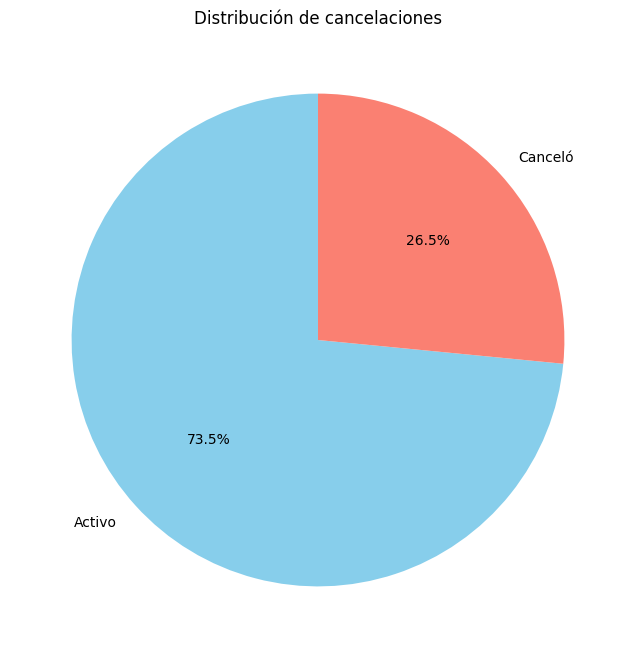

In [29]:
labels = ['Activo', 'Canceló']
churn_normalized = list(df_complete['Churn'].value_counts(normalize=True))
colors = ['skyblue', 'salmon']

plt.figure(figsize=(12, 8))

plt.pie(
    churn_normalized,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90
)

plt.title('Distribución de cancelaciones')

plt.show()

**Comentarios:**

Aunque un 26.5% de clientes que cancelan puede parecer bajo, en términos de Machine Learning, nos enfrentamos a un Desbalance de Clases.

- Tenemos una proporción 3:1 (por cada 3 clientes que se quedan, 1 se va).
- Si el modelo fuera "perezoso", podría simplemente decir que nadie se va y tendría una exactitud (Accuracy) del 73.5%. A priori parece correcto, pero sería erróneo porque no detectaría a ni un solo cliente en riesgo.
    - Esto justifica al 100% por qué la métrica principal es el AUC-ROC.
- Un 26.5% de churn es una cifra considerable para una empresa de telecomunicaciones.
    - Si logramos predecir correctamente a esos usuarios, el departamento de marketing tiene un campo de acción enorme para reducir esa cifra mediante las promociones que se mencionan.

#### **1.3.2 Análisis Bivariado:** - *Categóricas VS. Churn*

Nos interesan las variables que definen el comportamiento del cliente frente al servicio. Tomando en cuenta nuestra información y las variables disponibles, estas tienen lógica de negocio directa y suelen mostrar diferencias fuertes:

- `Type` (Contrato): Es, por excelencia, el mayor predictor. Los contratos mensuales suelen tener fugas masivas comparados con los de 2 años.

- `InternetService`: La fibra óptica suele ser más cara y, a veces, tiene más incidencias; compararla con DSL es vital.

- `PaymentMethod`: Históricamente, el "Electronic Check" tiene una tasa de cancelación altísima.

- `SeniorCitizen`: Para ver si la edad influye en la adopción tecnológica y retención.

##### **1.3.2.1 Gráfica `Type` VS. `Churn`**

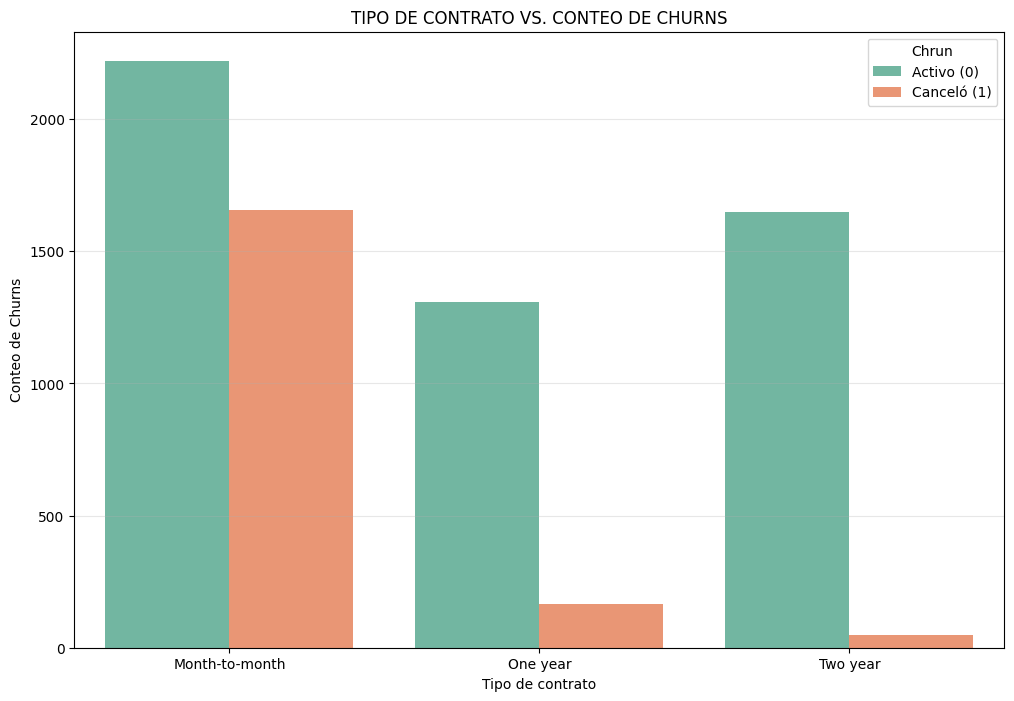

In [30]:
plt.figure(figsize=(12, 8))

sns.countplot(
    data=df_complete,
    x='Type',
    hue='Churn',
    palette='Set2'
)

plt.title('TIPO DE CONTRATO VS. CONTEO DE CHURNS')
plt.xlabel('Tipo de contrato')
plt.ylabel('Conteo de Churns')
plt.legend(title='Chrun', labels=['Activo (0)', 'Canceló (1)'])
plt.grid(True, axis='y', alpha=0.3)

plt.show()


**Comentarios:**

Desde una perspectiva de negocio y psicología del consumidor, los datos nos cuentan una historia clara:

- Month-to-month (Alta Volatilidad): Al no haber un contrato de permanencia, el "costo de salida" es casi cero. Si el cliente tiene un mal mes, ve una oferta de la competencia o simplemente quiere ahorrar, se va de inmediato. Aquí el Churn Rate es altísimo.
- One/Two Year (Fidelización): Aquí hay un compromiso contractual. El cliente suele recibir un mejor precio a cambio de quedarse. El Churn es drásticamente menor porque el cliente ya tomó la decisión de quedarse con la empresa por un tiempo largo.

##### **1.3.2.2 Gráfica `InternetService` VS. `Churn`**

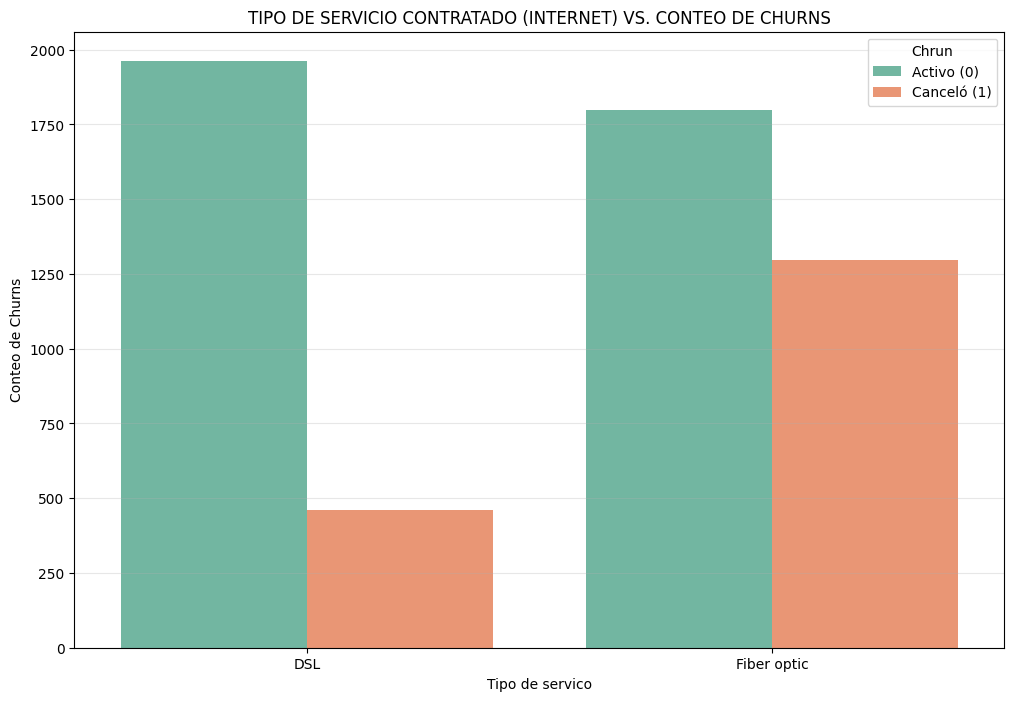

In [31]:
plt.figure(figsize=(12, 8))

sns.countplot(
    data=df_complete,
    x='InternetService',
    hue='Churn',
    palette='Set2'
)

plt.title('TIPO DE SERVICIO CONTRATADO (INTERNET) VS. CONTEO DE CHURNS')
plt.xlabel('Tipo de servico')
plt.ylabel('Conteo de Churns')
plt.legend(title='Chrun', labels=['Activo (0)', 'Canceló (1)'])
plt.grid(True, axis='y', alpha=0.3)

plt.show()


**Comentarios:**

Al observar que la tasa de cancelación en Fibra Óptica es de aproximadamente el 42% (aprox. 1300 de 3100), mientras que en DSL es solo del 19% (aprox. 450 de 2350). Posbile causa:

- La fibra suele ser más costosa. Si el cliente no percibe un valor proporcional al precio, el costo relativamente elevado del pago mensual motiva la salida.

##### **1.3.2.3 Gráfica `PaymentMethod` VS. `Churn`**

<Figure size 1200x800 with 0 Axes>

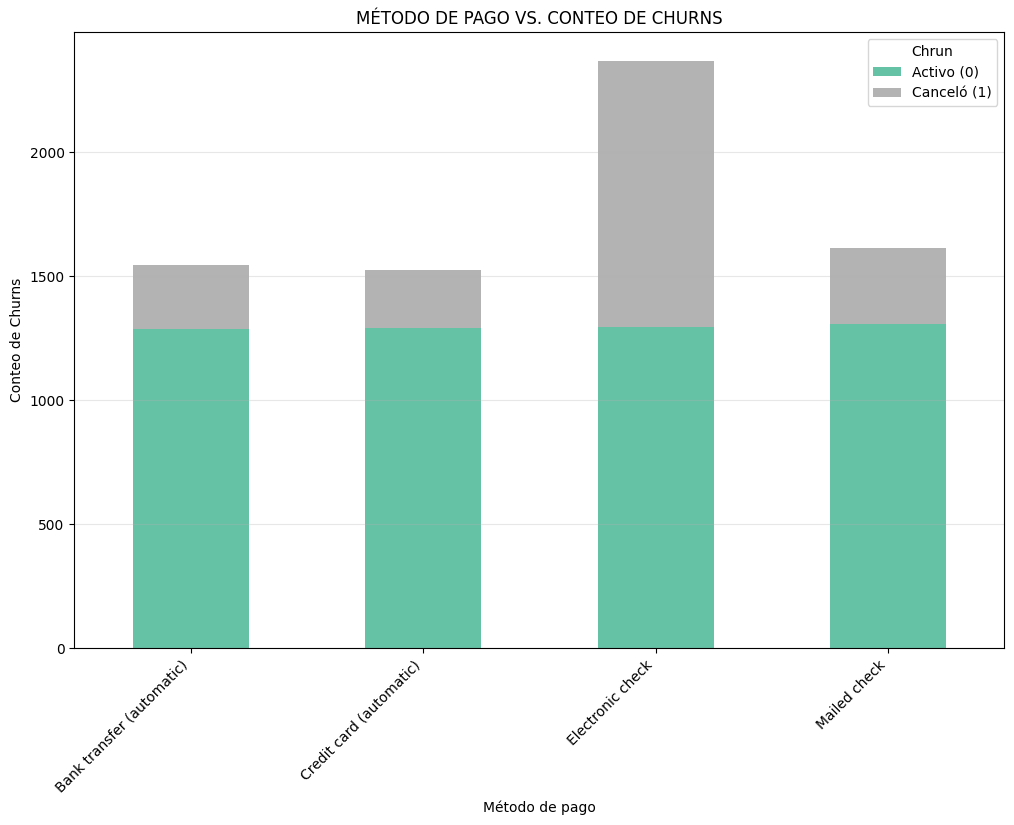

In [32]:
counts_PaymentMethod = df_complete.groupby(['PaymentMethod', 'Churn']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))

counts_PaymentMethod.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    colormap='Set2'
)

plt.title('MÉTODO DE PAGO VS. CONTEO DE CHURNS')
plt.xlabel('Método de pago')
plt.ylabel('Conteo de Churns')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Chrun', labels=['Activo (0)', 'Canceló (1)'])
plt.grid(True, axis='y', alpha=0.3)

plt.show()

**Comentarios:**

Aquí hay un hallazgo importante, mientras que los métodos automáticos "silencian" el pago, los métodos manuales obligan al cliente a tomar una decisión de compra cada mes.

- Los Automáticos: Tanto `Bank_Transfer` como `Credit_Card` tienen una tasa de cancelación muy baja (aprox. 13%). Al ser cobros automáticos, el cliente no tiene que interactuar con la factura; la relación es fluida y "olvidable".
- Punto Crítico (`Electronic_Check`): Aquí la tasa de cancelación se dispara a casi un 45% ( aprox .1100 de 2400).
    - A diferencia del cheque por correo (que es tradicional, al menos en Estados Unidos), el "Electronic Check" suele requerir que el usuario entre a un portal, vea el monto y autorice el pago. Cada vez que hace esto, se pregunta: ¿Realmente necesito este servicio?.

##### **1.3.2.4 Gráfica `SeniorCitizen` VS. `Churn`**

<Figure size 1200x800 with 0 Axes>

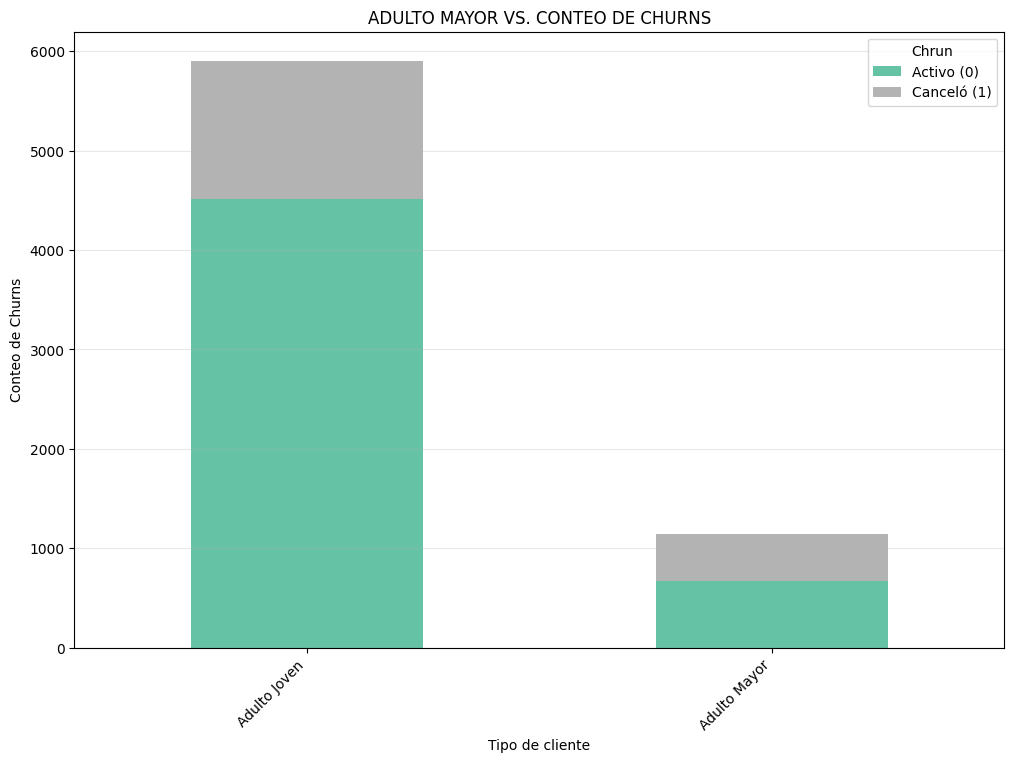

In [33]:
counts_SeniorCitizen = df_complete.groupby(['SeniorCitizen', 'Churn']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))

counts_SeniorCitizen.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    colormap='Set2'
)

plt.title('ADULTO MAYOR VS. CONTEO DE CHURNS')
plt.xlabel('Tipo de cliente')
plt.ylabel('Conteo de Churns')
plt.xticks(
    ticks=[0, 1],
    labels=['Adulto Joven', 'Adulto Mayor'],
    rotation=45,
    ha='right'
)
plt.legend(title='Chrun', labels=['Activo (0)', 'Canceló (1)'])
plt.grid(True, axis='y', alpha=0.3)

plt.show()

**Comentarios:**

No se encontró relación entre de un grupo a otro respecto al número de cancelaciones.

#### **1.3.3 Análisis Bivariado:** - *Numéricas VS. Churn*

Estos gráficos buscan comparar dónde se concentra el grueso de los datos para cada grupo (0 y 1). Se proponen los siguientes gráficos:

- Boxplot para `Tenure`: tomar en cuneta `Churn`, con ella podemos responder si la gente se va al principio del contrato (miedo al compromiso) o al final.
- Boxplot para `MonthlyCharges`: Responde a si existe un umbral de costos en los que la gente decide cancelar su contrato.

##### **1.3.3.1 Boxplot `Tenure` VS. `Churn`**

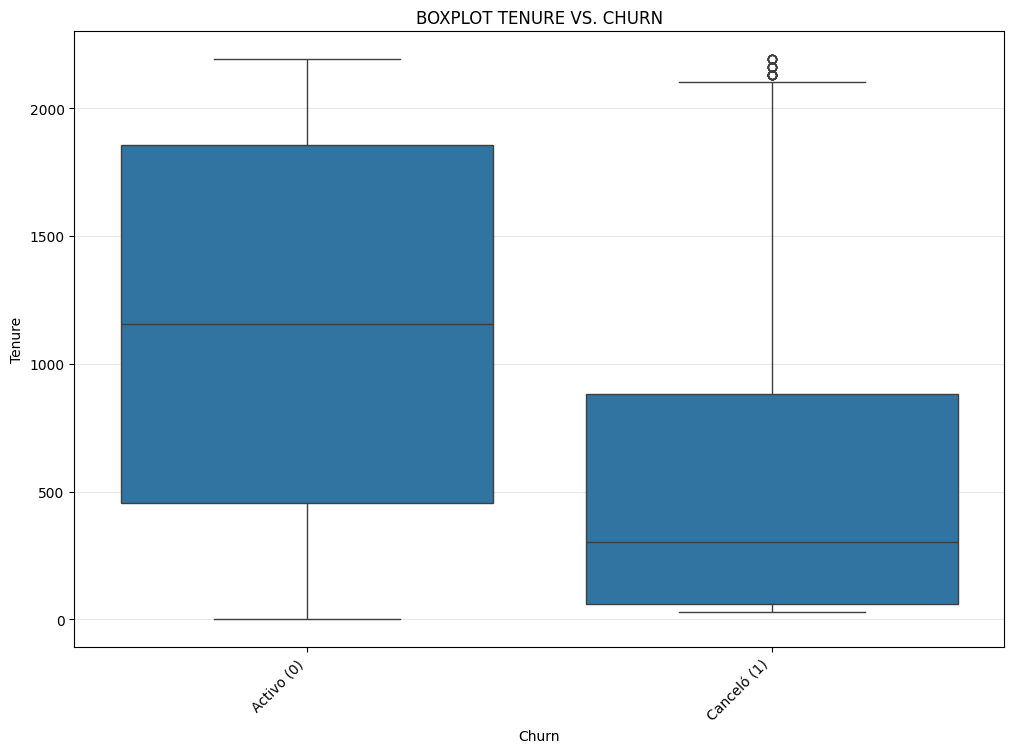

In [34]:
plt.figure(figsize=(12, 8))

sns.boxplot(
    data=df_complete,
    x='Churn',
    y='Tenure'
)

plt.title('BOXPLOT TENURE VS. CHURN')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.xticks(
    ticks=[0, 1],
    labels=['Activo (0)', 'Canceló (1)'],
    rotation=45,
    ha='right'
)
plt.grid(True, axis='y', alpha=0.3)

plt.show()


**Comentarios:**

- Los Clientes leales (Activo = 0): Con una mediana ($Q_2$) de 1600, vemos que la mayoría de los clientes que se quedan tienen una antigüedad considerable. El hecho de que el $Q_3$ sea 1800 y el bigote superior llegue a 2400 indica una base de clientes muy madura y estable.

- Los CLientes Fugaces (Canceló = 1): Aquí está la clave. La mediana es de solo 300. Esto significa que el 50% de las personas que se van lo hacen antes de los 300 días (aproximadamente 10 meses).
    - Interpretación: Existe una ventana crítica entre el día 0 y el día 850 ($Q_3$). Si un cliente supera los 2.3 años (850 días), la probabilidad de que se vaya cae drásticamente.

##### **1.3.3.2 Boxplot `MonthlyCharges` VS. `Churn`**

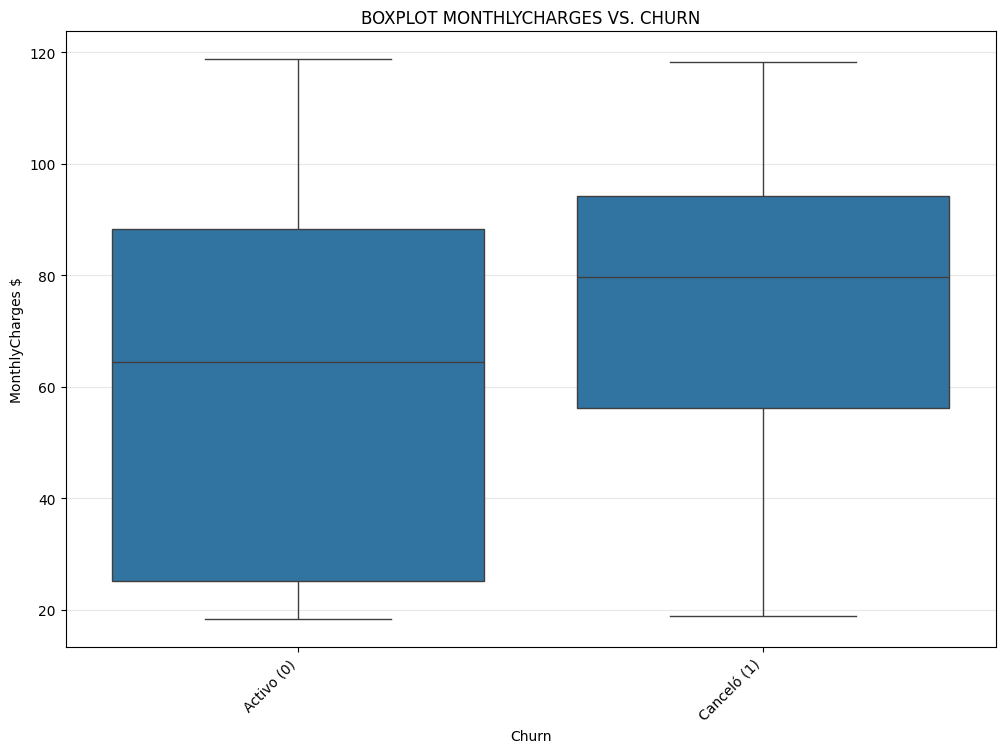

In [35]:
plt.figure(figsize=(12, 8))

sns.boxplot(
    data=df_complete,
    x='Churn',
    y='MonthlyCharges'
)

plt.title('BOXPLOT MONTHLYCHARGES VS. CHURN')
plt.xlabel('Churn')
plt.ylabel('MonthlyCharges $')
plt.xticks(
    ticks=[0, 1],
    labels=['Activo (0)', 'Canceló (1)'],
    rotation=45,
    ha='right'
)
plt.grid(True, axis='y', alpha=0.3)

plt.show()

**Comentarios:**

- Los "Económicos" son Leales (Activo = 0): El 25% de los clientes que se quedan ($Q_1$) pagan solo 25 aprox. Esto sugiere que Interconnect tiene una base muy sólida de clientes con planes básicos (posiblemente solo teléfono o DSL) que no tienen intención de irse porque el costo es insignificante.

- El "Umbral del Costo - Beneficio Percibido" (Canceló = 1): Aquí la diferencia es drástica. El 25% de los que se van ($Q_1$) ya están pagando 57, que es casi el valor de la mediana del grupo que se queda (65).
    - Interpretación: La mayoría de las cancelaciones ocurren cuando la factura supera los 70  - 80. Hay una concentración de riesgo en los planes de costo medio-alto.
    - Consistencia: Esto encaja perfectamente con el hallazgo anterior sobre la Fibra Óptica. La gente no se va por el servicio en sí, sino por la relación Costo-Beneficio del servicio más caro.

#### **1.3.4 Análisis de Correlación**

Nuestro objetivo con estos gráficos es detectar redundancia. Si dos variables están muy correlacionadas entre sí, el modelo no necesita ambas.

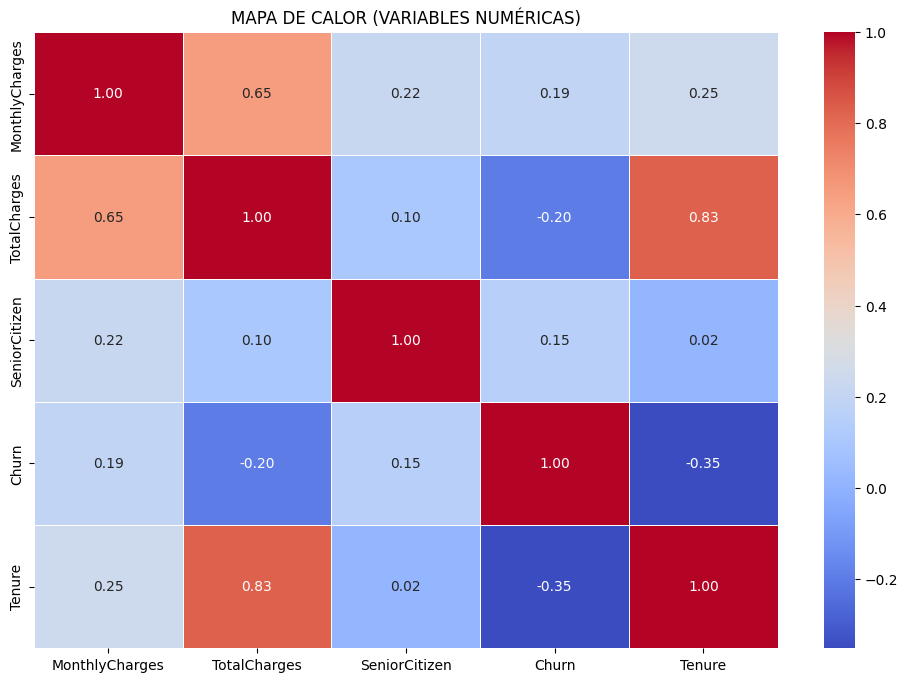

In [36]:
corr_HM = df_complete.select_dtypes(include='number').corr()

plt.figure(figsize=(12, 8))

sns.heatmap(
    corr_HM,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)

plt.title('MAPA DE CALOR (VARIABLES NUMÉRICAS)')

plt.show()

**Comentarios:**

A continuación se muestran los hallazgos:

1. `Tenure` y `TotalCharges` (0.8258):
    - Existe una correlación positiva muy fuerte (0.83). Es lógico: el "Cargo Total" es, en esencia, la acumulación de los "Cargos Mensuales" a lo largo del "Tiempo (Tenure)". A más meses contratados, mayor es el gasto total acumulado.
    - Se procede a marcar esto como una advertencia. Si conservamos ambas variables, el modelo podría recibir información redundante. En modelos lineales, esto puede inflar la varianza, aunque en modelos de boosting (como XGBoost o CatBoost) no suele ser un problema crítico.

2. `Churn` vs. `Tenure` (−0.3526):
    - Es una correlación negativa moderada. El signo negativo es clave: nos dice que a medida que la antigüedad (Tenure) sube, la probabilidad de cancelar (Churn) baja.
    - Esto confirma matemáticamente lo que vimos en el Boxplot: la lealtad se construye con el tiempo.

3. `Churn` vs. `MonthlyCharges` (0.1933):
    - Es una correlación positiva. A medida que el cargo mensual sube, la tendencia a cancelar también sube.
    - Hemos de nortar que `TotalCharges` tiene una correlación negativa con `Churn` (−0.1994). Esto porque `TotalCharges` está arrastrado por el `Tenure`. Los que tienen un `TotalCharges` muy alto son clientes que llevan años y, por lo tanto, no se van. Esto demuestra por qué los cargos mensuales son un mejor predictor de fuga que los cargos totales.

#### **1.3.5 Detección de OUTLIERS**

Buscamos ruido en los datos, estos valores aislados y fuera de contexto pueden causar ruido en el modelo. Se procede con variables prioritarias:

- `MonthlyCharges`: Existencia de cobros erróneos
- `TotalCharges`: Para detectar si hay valores acumulados que no guardan proporción con el tiempo de servicio.

#### 1.3.5.1 Detección de OUTLIERS: `MonthlyCharges`

In [37]:
# Cuartiles
q1_MonthlyCharges = df_complete['MonthlyCharges'].quantile(0.25)
q2_MonthlyCharges = df_complete['MonthlyCharges'].quantile(0.50)  # mediana
q3_MonthlyCharges = df_complete['MonthlyCharges'].quantile(0.75)

# IQR
iqr_MonthlyCharges = q3_MonthlyCharges - q1_MonthlyCharges

# Límites
limite_inferior_MonthlyCharges = q1_MonthlyCharges - 1.5 * iqr_MonthlyCharges
limite_superior_MonthlyCharges = q3_MonthlyCharges + 1.5 * iqr_MonthlyCharges

# Outliers
outliers_MonthlyCharges = df_complete[(df_complete['MonthlyCharges'] < limite_inferior_MonthlyCharges) | (df_complete['MonthlyCharges'] > limite_superior_MonthlyCharges)]

if outliers_MonthlyCharges.empty:
    outliers_MonthlyCharges = 'No se encontraron outliers'





Resumen del Boxplot de 'MonthlyCharges'
-----------------------------
Q1 (25%): $35.5
Q2 (Mediana): $70.35
Q3 (75%): $89.85
IQR (Q3 - Q1): 54.349999999999994

Límite inferior: $-46.02499999999999
Límite superior: $171.375

Outliers detectados: No se encontraron outliers



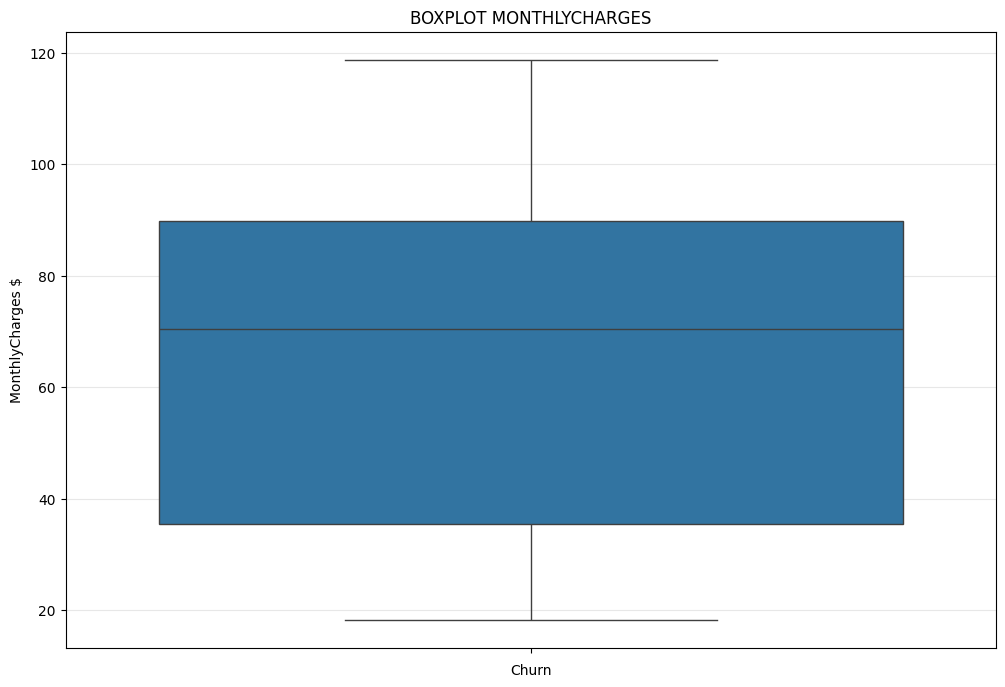

In [38]:
# Outliers

print(f"""
Resumen del Boxplot de 'MonthlyCharges'
-----------------------------
Q1 (25%): ${q1_MonthlyCharges}
Q2 (Mediana): ${q2_MonthlyCharges}
Q3 (75%): ${q3_MonthlyCharges}
IQR (Q3 - Q1): {iqr_MonthlyCharges}

Límite inferior: ${limite_inferior_MonthlyCharges}
Límite superior: ${limite_superior_MonthlyCharges}

Outliers detectados: {outliers_MonthlyCharges}
""")


# Boxplot

plt.figure(figsize=(12,8))

sns.boxplot(
    data=df_complete,
    y='MonthlyCharges'
)

plt.title('BOXPLOT MONTHLYCHARGES')
plt.xlabel('Churn')
plt.ylabel('MonthlyCharges $')
plt.grid(True, axis='y', alpha=0.3)

plt.show()

**Comentarios:**

No se detectaron Outliers

#### 1.3.5.2 Detección de OUTLIERS: `TotalCharges`

In [39]:
# Cuartiles
q1_TotalCharges = df_complete['TotalCharges'].quantile(0.25)
q2_TotalCharges = df_complete['TotalCharges'].quantile(0.50)  # mediana
q3_TotalCharges = df_complete['TotalCharges'].quantile(0.75)

# IQR
iqr_TotalCharges = q3_TotalCharges - q1_TotalCharges

# Límites
limite_inferior_TotalCharges = q1_TotalCharges - 1.5 * iqr_TotalCharges
limite_superior_TotalCharges = q3_TotalCharges + 1.5 * iqr_TotalCharges

# Outliers
outliers_TotalCharges = df_complete[(df_complete['TotalCharges'] < limite_inferior_TotalCharges) | (df_complete['TotalCharges'] > limite_superior_TotalCharges)]

if outliers_TotalCharges.empty:
    outliers_TotalCharges = 'No se encontraron outliers'



Resumen del Boxplot de 'TotalCharges'
-----------------------------
Q1 (25%): $401.45
Q2 (Mediana): $1397.475
Q3 (75%): $3794.7375
IQR (Q3 - Q1): 3393.2875000000004

Límite inferior: $-4688.481250000001
Límite superior: $8884.66875

Outliers detectados: No se encontraron outliers



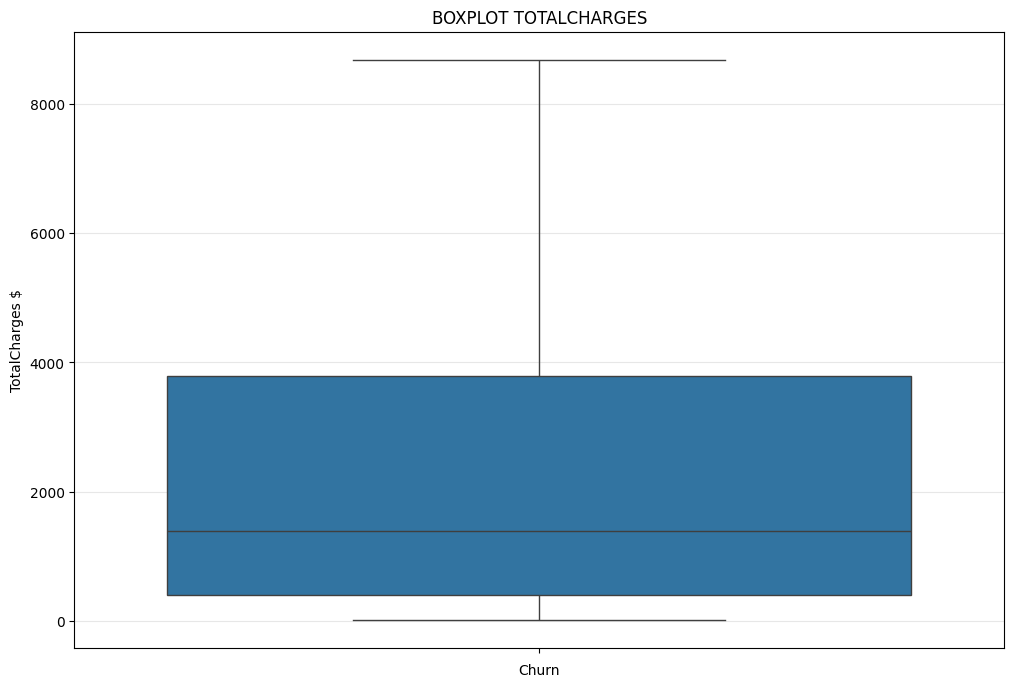

In [40]:
# Outliers

print(f"""
Resumen del Boxplot de 'TotalCharges'
-----------------------------
Q1 (25%): ${q1_TotalCharges}
Q2 (Mediana): ${q2_TotalCharges}
Q3 (75%): ${q3_TotalCharges}
IQR (Q3 - Q1): {iqr_TotalCharges}

Límite inferior: ${limite_inferior_TotalCharges}
Límite superior: ${limite_superior_TotalCharges}

Outliers detectados: {outliers_TotalCharges}
""")


# Boxplot

plt.figure(figsize=(12,8))

sns.boxplot(
    data=df_complete,
    y='TotalCharges'
)

plt.title('BOXPLOT TOTALCHARGES')
plt.xlabel('Churn')
plt.ylabel('TotalCharges $')
plt.grid(True, axis='y', alpha=0.3)

plt.show()

**Comentarios:**

No se detectaron Outliers

---

## **SECCIÓN 2:** *Plan de trabajo*

### **Plan de Trabajo**

Este es el resumen de propuesta de trabajo para nuestro dataset de datos según lo encontrado.

- **Paso 1 (Sección 3):** Preprocesamiento y Feature Engineering Final (Hecho en su mayoría)
    - *Consolidar el dataset mediante un Left Join, tratar los nulos como categorías "No" y transformar las fechas para extraer el Target (Churn) y la variable de magnitud Tenure. Convertiremos TotalCharges a flotante, manejando los espacios en blanco que detectamos en el EDA.*

- **Paso 2 (Sección 4):** División, codificación y Escalado de Datos
    - *Dividir el dataset en conjuntos de entrenamiento y prueba (80/20) aplicando estratificación para mantener el desbalance del 26.5% de Churn.*
    - *Transformar las variables categóricas mediante One-Hot Encoding (para algoritmos lineales) o Label Encoding (para modelos de árboles). Escalaremos las variables numéricas (MonthlyCharges, Tenure) para asegurar que el modelo no dé peso excesivo a los valores más grandes.*
    - *Diferenciar entre One-Hot Encoding para la estabilidad de la Regresión Logística y Ordinal/Native Encoding para los modelos de ensamble, permitiendo que CatBoost aproveche su algoritmo interno de procesamiento de categorías.*

- **Paso 3 (Sección 5):** Selección, entrenamiento y optimización de modelos e hiperparámetros
    - *Entrenaremos y compararemos cuatro modelo: un modelo base (Regresión Logística), un ensamble (Random Forest) y dos modelos de descenso de gradiente (CatBoost y LightGBM).*
    - *Utilizar herramientas de búsqueda (como GridSearchCV o RandomizedSearchCV) para ajustar los parámetros internos de los modelos seleccionados. El objetivo principal será maximizar la métrica AUC-ROC, buscando superar el umbral de 0.88 solicitado.*

- **Paso 4 (Sección 6):** Evaluación Final e Informe de Resultados
    - *Crear una Función que permite evaluar y graficar los resultados:*
        - *La herramienta de diagnóstico de 6 paneles que sincroniza marcadores de umbral en curvas ROC y PRC permitirá una visualización inédita del intercambio entre Precisión y Recall.*
    - *Validar el modelo final con el conjunto de prueba (test set) y generar una matriz de confusión para entender el desempeño real. Concluiremos con un informe estratégico que traduzca las métricas técnicas en recomendaciones de negocio.*
    - *Ejecutar cambios respecto al estándar de 0.5, priorizando la captura de desertores (Recall) y la eficiencia del presupuesto de marketing.*

## **SECCIÓN 3:** *Feature Engineering*

Esta es la sección donde adecuamos el dataset para que el modelo aprenda y no se confunda con la información dada. En este caso, despues del left join implementado entre todos los sets de datos es perable encontrar `NaN's`, los cuales no son errores, sino información implícita que debemos hacer explícita.

- Búsqueda de `NaN's` en datos categóricos:
    - El problema es que tenemos clientes que no aparecen en las tablas de `internet` o `phone`. Al unirlas, Pandas pone `NaN`. Para el modelo, un NaN es un vacío que no puede procesar, pero para nosotros significa: "El cliente no tiene este servicio".

- Búsqueda de `NaN's` en datos numéricos: Se procede a realizar la búsqueda.

In [41]:
print(df_complete.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

In [42]:
non_numeric_data = df_complete.select_dtypes(exclude=['number', 'datetime'])
#print(non_numeric_data)

for col in non_numeric_data.columns:
    print(f'Columna: {col}')
    print(non_numeric_data[col].unique())
    print('-' * 40)

Columna: customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------
Columna: Type
['Month-to-month' 'One year' 'Two year']
----------------------------------------
Columna: PaperlessBilling
['Yes' 'No']
----------------------------------------
Columna: PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
----------------------------------------
Columna: gender
['Female' 'Male']
----------------------------------------
Columna: Partner
['Yes' 'No']
----------------------------------------
Columna: Dependents
['No' 'Yes']
----------------------------------------
Columna: InternetService
['DSL' 'Fiber optic' nan]
----------------------------------------
Columna: OnlineSecurity
['No' 'Yes' nan]
----------------------------------------
Columna: OnlineBackup
['Yes' 'No' nan]
----------------------------------------
Columna: DeviceProtection
['No' 'Yes' nan]
------

**Comentarios:**

Dado que los `NaN` son interpretados como ausencia de servicios, debemos buscalos e impoutarlos en todo el DataFrame. En este caso, como todas las variables afectadas son categóricas y su ausencia implica que el servicio no existe, `'No'` es la etiqueta adecuada.

1. Servicios de Internet
    - Columnas: `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`.
    - Lógica: Si un cliente tiene `NaN` en `InternetService`, significa que no tiene internet. Por lo tanto, en las columnas de seguridad o streaming, su valor también debería ser "No".
    - Propuesta: Reemplazar `NaN` por la cadena `'No'`.

2. Servicios de Telefonía
    - Columna: `MultipleLines`.
    - Lógica: Si el cliente no tiene servicio de teléfono, no puede tener múltiples líneas.
    - Propuesta: Reemplazar `NaN` por la cadena `'No'`.

---

In [43]:
cols_nan = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in cols_nan:
    df_complete[col] = df_complete[col].fillna('No')

In [44]:
non_numeric_data = df_complete.select_dtypes(exclude=['number', 'datetime'])
#print(non_numeric_data)

for col in non_numeric_data.columns:
    print(f'Columna: {col}')
    print(non_numeric_data[col].unique())
    print('-' * 40)

Columna: customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------
Columna: Type
['Month-to-month' 'One year' 'Two year']
----------------------------------------
Columna: PaperlessBilling
['Yes' 'No']
----------------------------------------
Columna: PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
----------------------------------------
Columna: gender
['Female' 'Male']
----------------------------------------
Columna: Partner
['Yes' 'No']
----------------------------------------
Columna: Dependents
['No' 'Yes']
----------------------------------------
Columna: InternetService
['DSL' 'Fiber optic' 'No']
----------------------------------------
Columna: OnlineSecurity
['No' 'Yes']
----------------------------------------
Columna: OnlineBackup
['Yes' 'No']
----------------------------------------
Columna: DeviceProtection
['No' 'Yes']
-----------------

In [45]:
numeric_data = df_complete.select_dtypes(include=['number'])

for col in numeric_data.columns:
    print(f'Columna: {col}')
    print(numeric_data[col].isna().sum())
    print('-' * 40)

Columna: MonthlyCharges
0
----------------------------------------
Columna: TotalCharges
11
----------------------------------------
Columna: SeniorCitizen
0
----------------------------------------
Columna: Churn
0
----------------------------------------
Columna: Tenure
0
----------------------------------------


**Comentarios:** 

Se han encontrado datos numéricos con valores nulos. Dado que corresponden a la columna `TotalCharges` se asume el siguiente escenario:

- Si un cliente tiene un valor nulo en "Cargos Totales", lo más probable es que sea un cliente recién llegado.
    - Debemos comprobar si estos 11 clientes tienen un `Tenure` (antigüedad) de 0 o 1 mes. Como apenas están empezando, el sistema aún no ha procesado su primer pago total o el dato venía como un espacio en blanco que, al convertirse a número, se volvió `NaN`.

---

In [46]:
# Buscando información sobre valores NaN en TotalCharges

BM_1 = df_complete['TotalCharges'].isna() == True

print(df_complete[BM_1][['TotalCharges', 'Tenure']])

      TotalCharges  Tenure
488            NaN       0
753            NaN       0
936            NaN       0
1082           NaN       0
1340           NaN       0
3331           NaN       0
3826           NaN       0
4380           NaN       0
5218           NaN       0
6670           NaN       0
6754           NaN       0


## Comentarios 

Se ha comprobado la relación entre `Tenure = 0` y `TotalCharges = NaN`, por lo tanto se propone la siguiente solución:

- Imputación con Cero: Si el cliente acaba de contratar, técnicamente su cargo total acumulado es 0.

--- 

In [47]:
# Imputación

df_complete['TotalCharges'] = df_complete['TotalCharges'].fillna(0).astype('int')

print(df_complete[BM_1][['TotalCharges', 'Tenure']])

      TotalCharges  Tenure
488              0       0
753              0       0
936              0       0
1082             0       0
1340             0       0
3331             0       0
3826             0       0
4380             0       0
5218             0       0
6670             0       0
6754             0       0


In [48]:
# Comprobación final de valores nulos

print(df_complete.isna().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
Churn               0
Tenure              0
dtype: int64


## **SECCIÓN 4:** *División, codificación y Escalado de Datos*

### **4.1 División (Split de datos)**

La división o split de datos debe realizarse en primera instancia ya que si codificamos o escalamoss antes de dividir, estaríamos propiciando Data Leakage (Fuga de Datos), es por ello que debemos realizar el `train_test_split` antes de cualquier transformación que dependa de estadísticas del conjunto de datos (como la media para escalar o las categorías para el encoding).

> Habrá que tomar en cuenta que debemos eliminar las columnas `customerID`, `BeginDate` y `EndDate`.

Considerando que el tamaño de nuestro dataset es de $7,043$ registros, esta es la manera de proceder respecto al split de datos:

- Tamaño del split: $80\%$ Entrenamiento y $20\%$ Prueba. Esto nos deja con aprox. 5,634 filas para aprender y aprox. 1,409 para validar.

Hay que tener en cuenta la siguientes consideración:

- Usaremos `stratify=y` ya que nuestro `Churn` es de $26.5\%$, por lo tanto esto garantiza que ese ratio de 3:1 se mantenga exacto en ambos sets.



In [49]:
# Eliminando columnas innecesarias
data_clean = df_complete.copy()
data_clean = data_clean.drop(columns=['customerID', 'BeginDate', 'EndDate'])

In [50]:
data_clean.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'Churn', 'Tenure'],
      dtype='object')

In [51]:
# Definiendo Features y Target
y = data_clean['Churn']
X = data_clean.drop(columns=['Churn'])

In [52]:
# Creando el split maestro
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=230598,
    stratify=y
)

In [53]:
# Comprobar dimensiones
print("Dimensiones X_train:", X_train.shape)
print("Dimensiones X_test:", X_test.shape)
print("Dimensiones y_train:", y_train.shape)
print("Dimensiones y_test:", y_test.shape)

# Comprobar columnas en X_train y X_test
print("\nColumnas en X_train:", X_train.columns.tolist())
print("Columnas en X_test:", X_test.columns.tolist())

Dimensiones X_train: (5634, 18)
Dimensiones X_test: (1409, 18)
Dimensiones y_train: (5634,)
Dimensiones y_test: (1409,)

Columnas en X_train: ['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Tenure']
Columnas en X_test: ['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Tenure']


### **4.2 Codificación y Escalado de Datos**

Dadas las características de nuestros datos, se presenta a continuación la forma de Codificación de los Datos en función de las necesidades de los modelos propuestos en la sección 2: Plan de trabajo.

1. Para Regresión Logística: One-Hot Encoding (OHE):
    - Al ser un modelo basado en distancias y coeficientes, si no escalamos, por ejemplo `TotalCharges` (valores de miles) "aplastará" a `SeniorCitizen` (0 o 1).
    - Si usamos números como 0, 1, 2 para `Type`, el modelo pensará que "Two Year" (2) es más grande o mejor que "Month-to-month" (0). Esto es considerado un error en la interpretación de las categorías. La implementación de OHE crea columnas binarias independientes.
  
2. Para Árboles (Random Forest): Ordinal/Label Encoding
    - Los árboles de decisión simplemente "acotan" los datos.
    - Los árboles no se distraen con las escalas (un corte en 10 es igual de fácil que un corte en 10,000). El Ordinal Encoding es preferible sobre el OHE aquí para evitar que el árbol se vuelva demasiado profundo y complejo al manejar cientos de columnas binarias.

3. Para CatBoost: Sin modeificar, solo declarar columnas categóricas
    - Es el modelo más inteligente de los tres. Su algoritmo de Categorical Encoding interno es superior al OHE o al Label Encoding manual.

Referente al escalamiento, se debe implementar ya que es vital para Regresión Logística. Los modelos de árboles (Random Forest/CatBoost) son inmutables ante el escalamiento.

Se proponen tres versiones de nuestros datos en función de las necesidades del modelo que los implementará, tomar en cuenta que todos parten del split de datos y este se debe de realizar una vez.

- **Regresión logística:** `df_linear`
    - Requerimientos técnicos: Con OHE y Escalado.
    - Secuencia de ejecución: 1. Split $\Rightarrow$ 2. OHE $\Rightarrow$ 3. Escalado
    - Resultado final: Un set de datos con muchas columnas binarias y valores entre −3 y 3.

- **Random Forest:** `df_rf`
    - Requerimientos técnicos: Ordinal Encoding, sin escalado.
    - Secuencia de ejecución: 1. Split $\Rightarrow$ 2. Ordinal Encoding
    - Resultado final: Un set de datos con las categorías originales convertidas a números (0,1,2).

- **CatBoost:** `df_cb`
    - Requerimientos técnicos: Ninguno, maneja adecuadamente categorías nativas.
    - Secuencia de ejecución: 1. Split $\Rightarrow$ 2. Identificar índices de columnas categóricas.
    - Resultado final: El set de datos original (con texto) pero indicándole al modelo qué columnas son categorías.

- **LightGBM:** `df_lgb`
    - Requerimientos técnicos: Requiere que las variables categóricas sean transformadas explícitamente al tipo de dato `category` de Pandas. Al igual que CatBoost, no requiere escalado.
    - Secuencia de ejecución: Split $\Rightarrow$ 2. Conversión de columnas de texto a tipo `category` mediante `.astype('category')`.
    - Resultado final: Un DataFrame donde las variables numéricas se mantienen igual, pero las variables de texto (como `Type` o `InternetService`) tienen el tipo de dato especial `category`, permitiendo que el modelo las indexe automáticamente.

#### **4.2.1 Dataset para Regresión logística:** `df_linear`

##### A. Clasificación de Variables (Celdas 1 y 2)

El primer paso corresponde la **segmentación**. Se procede a separar los datos en dos grupos lógicos:

* **Categóricos:** Datos que representan cualidades o grupos.
* **Numéricos:** Datos que representan magnitudes o cantidades.

##### B. Diseño del Transformador (Celda 3)

Aquí se define el plano de procesamiento mediante `ColumnTransformer`. Se aplican dos procesos distintos simultáneamente:

* **OneHotEncoder:** Convierte el texto en columnas de bits (0 y 1). El uso de `drop='first'` es vital para modelos lineales porque elimina la redundancia matemática (evita la trampa de la variable ficticia).
* **StandardScaler:** Normaliza las señales numéricas para que tengan media 0 y desviación estándar 1.

##### C. Calibración y Transformación de Entrenamiento (Celda 4)

Con `.fit_transform()`, el transformador realiza dos tareas en un solo paso sobre `X_train`:

1. **Aprende:** Calcula la media ($\mu$) y desviación ($\sigma$) de los números, y registra qué categorías existen (ej. qué tipos de contrato hay).
2. **Ejecución:** Aplica esos cálculos para convertir la tabla original en la matriz numérica.

##### D. Transformación de Test (Celda 5)

Al usar solo `.transform()`, se obliga al conjunto de prueba a seguir las reglas que aprendió del entrenamiento, así, no se recalcula la media ni los nombres de las categorías con los datos de prueba. Esto simula cómo se comportaría el modelo en el futuro con datos que nunca ha visto.

##### E. Reconstrucción y Etiquetado (Celdas 6 y 7)

Finalmente, se recupera la identidad de los datos. El resultado de los pasos anteriores correspondía a un arreglo de NumPy. Al usar `get_feature_names_out()`, se le asigna nuevamente el nombre a cada columna, esto nos permite verificar que:

* Las categorías ahora tienen prefijos como `cat__`.
* Las numéricas tienen el prefijo `num__`.
* El orden de las columnas es consistente en ambos sets.


In [54]:
categorical_columns = list(X_train.select_dtypes(exclude=['number']))
print(categorical_columns)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [55]:
numerical_columns = list(X_train.select_dtypes(include=['number']))
print(numerical_columns)

['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Tenure']


In [56]:
transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ]
)

In [57]:
# Ajustando y transformando conjunto de entrenamiento

X_train_linear = transformer.fit_transform(X_train)

print(X_train_linear)

[[ 0.          1.          1.         ... -0.47910628 -0.44205987
   1.09526138]
 [ 1.          0.          0.         ... -0.17261845 -0.44205987
   0.07151253]
 [ 0.          0.          1.         ... -0.36854069  2.26213701
  -0.13404334]
 ...
 [ 0.          1.          0.         ... -0.19428931 -0.44205987
   1.58563976]
 [ 0.          0.          0.         ... -0.58480699 -0.44205987
  -0.54112457]
 [ 0.          1.          0.         ... -0.8598942  -0.44205987
  -0.70637537]]


In [58]:
# Transformando conjunto de prueba

X_test_linear = transformer.transform(X_test)

print(X_test_linear)

[[ 0.          0.          1.         ...  0.59736037 -0.44205987
   0.47993727]
 [ 1.          0.          1.         ...  0.30546719  2.26213701
   0.8897055 ]
 [ 0.          0.          1.         ... -0.76259647 -0.44205987
  -0.90924424]
 ...
 [ 0.          1.          0.         ... -0.73517621 -0.44205987
  -0.01044112]
 [ 0.          0.          1.         ... -0.68298925  2.26213701
  -0.78832902]
 [ 1.          0.          0.         ...  1.30807603 -0.44205987
   1.46203754]]


In [59]:
# Asignando los nombres de las columnas a X_train

X_train_linear = pd.DataFrame(X_train_linear, columns=transformer.get_feature_names_out())

print(X_train_linear.columns)

Index(['cat__Type_One year', 'cat__Type_Two year', 'cat__PaperlessBilling_Yes',
       'cat__PaymentMethod_Credit card (automatic)',
       'cat__PaymentMethod_Electronic check',
       'cat__PaymentMethod_Mailed check', 'cat__gender_Male',
       'cat__Partner_Yes', 'cat__Dependents_Yes',
       'cat__InternetService_Fiber optic', 'cat__InternetService_No',
       'cat__OnlineSecurity_Yes', 'cat__OnlineBackup_Yes',
       'cat__DeviceProtection_Yes', 'cat__TechSupport_Yes',
       'cat__StreamingTV_Yes', 'cat__StreamingMovies_Yes',
       'cat__MultipleLines_Yes', 'num__MonthlyCharges', 'num__TotalCharges',
       'num__SeniorCitizen', 'num__Tenure'],
      dtype='object')


In [60]:
# Asignando los nombres de las columnas a X_test

X_test_linear = pd.DataFrame(X_test_linear, columns=transformer.get_feature_names_out())

print(X_test_linear.columns)

Index(['cat__Type_One year', 'cat__Type_Two year', 'cat__PaperlessBilling_Yes',
       'cat__PaymentMethod_Credit card (automatic)',
       'cat__PaymentMethod_Electronic check',
       'cat__PaymentMethod_Mailed check', 'cat__gender_Male',
       'cat__Partner_Yes', 'cat__Dependents_Yes',
       'cat__InternetService_Fiber optic', 'cat__InternetService_No',
       'cat__OnlineSecurity_Yes', 'cat__OnlineBackup_Yes',
       'cat__DeviceProtection_Yes', 'cat__TechSupport_Yes',
       'cat__StreamingTV_Yes', 'cat__StreamingMovies_Yes',
       'cat__MultipleLines_Yes', 'num__MonthlyCharges', 'num__TotalCharges',
       'num__SeniorCitizen', 'num__Tenure'],
      dtype='object')


#### **4.2.2 Dataset para Random Forest:** `df_rf`

##### A. Diseño del Transformador (Celda 1)

En lugar de crear columnas nuevas (como hicimos en OHE), se configuró `transformer_rf` que:

* **Codifica:** Toma las 14 columnas categóricas y les asigna un número entero único a cada categoría.
* **Protege:** Con `handle_unknown='use_encoded_value'`, nos aseguramos de que si el modelo encuentra una categoría nueva en el futuro, no se detenga, sino que le asigne un `-1`.
* **Preserva:** El parámetro `remainder='passthrough'` es vital aquí. Se le indica al transformador: "No modificar las variables numéricas (`Tenure`, `Charges`), dejarlas pasar tal cual están". Esto es correcto porque los árboles no necesitan que los números estén escalados.

##### B. Entrenamiento y Transformación de Señales (Celda 2)

Al ejecutar `fit_transform` en `X_train`:

1. El codificador analiza todas las palabras y crea un diccionario interno (ejemplo: *Month-to-month* = 0, *One year* = 1, *Two year* = 2).
2. Aplica ese diccionario a la tabla, convirtiendo todo en la matriz de tipo `float`. Notar que los números grandes (como el `1798.0` al final de la primera fila) son las variables numéricas que "pasaron de largo" sin cambios.

##### C. Aplicación Consistente en Prueba (Celda 3)

Con `.transform(X_test)`, se aplica el diccionario aprendido en el entrenamiento a los datos de prueba. Esto garantiza que cualquier número signifique lo mismo en ambos sets. Nuevamente, evitamos la fuga de datos al no aprender nada nuevo de `X_test`.

##### D. Reconstrucción y Etiquetado (Celdas 4 y 5)

Al reconstruir los DataFrames con `get_feature_names_out()`, reasignamos los nombres de manera que:

* Las columnas categóricas ahora tienen el prefijo `ord__`.
* Las columnas numéricas tienen el prefijo `remainder__`.
Esto nos permite verificar visualmente que el "passthrough" funciona adecuadamente.


In [61]:
transformer_rf = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)
    ],
    remainder='passthrough'
)

In [62]:
# Ajustando y transformando conjunto de entrenamiento

X_train_rf = transformer_rf.fit_transform(X_train)

print(X_train_rf)

[[2.000e+00 1.000e+00 0.000e+00 ... 1.192e+03 0.000e+00 1.798e+03]
 [1.000e+00 0.000e+00 3.000e+00 ... 1.885e+03 0.000e+00 1.036e+03]
 [0.000e+00 1.000e+00 2.000e+00 ... 1.442e+03 1.000e+00 8.830e+02]
 ...
 [2.000e+00 0.000e+00 0.000e+00 ... 1.836e+03 0.000e+00 2.163e+03]
 [0.000e+00 0.000e+00 3.000e+00 ... 9.530e+02 0.000e+00 5.800e+02]
 [2.000e+00 0.000e+00 3.000e+00 ... 3.310e+02 0.000e+00 4.570e+02]]


In [63]:
# Transformando conjunto de prueba

X_test_rf = transformer_rf.transform(X_test)

print(X_test_rf)

[[0.000e+00 1.000e+00 1.000e+00 ... 3.626e+03 0.000e+00 1.340e+03]
 [1.000e+00 1.000e+00 2.000e+00 ... 2.966e+03 1.000e+00 1.645e+03]
 [0.000e+00 1.000e+00 3.000e+00 ... 5.510e+02 0.000e+00 3.060e+02]
 ...
 [2.000e+00 0.000e+00 3.000e+00 ... 6.130e+02 0.000e+00 9.750e+02]
 [0.000e+00 1.000e+00 2.000e+00 ... 7.310e+02 1.000e+00 3.960e+02]
 [1.000e+00 0.000e+00 1.000e+00 ... 5.233e+03 0.000e+00 2.071e+03]]


In [64]:
# Asignando los nombres de las columnas a X_train

X_train_rf = pd.DataFrame(X_train_rf, columns=transformer_rf.get_feature_names_out())

print(X_train_rf.columns)

Index(['ord__Type', 'ord__PaperlessBilling', 'ord__PaymentMethod',
       'ord__gender', 'ord__Partner', 'ord__Dependents',
       'ord__InternetService', 'ord__OnlineSecurity', 'ord__OnlineBackup',
       'ord__DeviceProtection', 'ord__TechSupport', 'ord__StreamingTV',
       'ord__StreamingMovies', 'ord__MultipleLines',
       'remainder__MonthlyCharges', 'remainder__TotalCharges',
       'remainder__SeniorCitizen', 'remainder__Tenure'],
      dtype='object')


In [65]:
# Asignando los nombres de las columnas a X_test

X_test_rf = pd.DataFrame(X_test_rf, columns=transformer_rf.get_feature_names_out())

print(X_test_rf.columns)

Index(['ord__Type', 'ord__PaperlessBilling', 'ord__PaymentMethod',
       'ord__gender', 'ord__Partner', 'ord__Dependents',
       'ord__InternetService', 'ord__OnlineSecurity', 'ord__OnlineBackup',
       'ord__DeviceProtection', 'ord__TechSupport', 'ord__StreamingTV',
       'ord__StreamingMovies', 'ord__MultipleLines',
       'remainder__MonthlyCharges', 'remainder__TotalCharges',
       'remainder__SeniorCitizen', 'remainder__Tenure'],
      dtype='object')


#### **4.2.3 Dataset para CatBoost:** `df_cb`

Para CatBoost no es necesario crear un nuevo set de datos especializado en ese modelo, en él, podemos usar los datos crudos salidos del Split. 

Hay que considerar que es necesario indicar los índices de las columnas categóricas al modelo, si no se hace esto, el modelo intentará tratar los textos como números (lo cual dará error) o, si ya son números (como un ID), los tratará como magnitudes físicas (donde 2 es el doble de 1), perdiendo la esencia de que son "etiquetas".

Al saber cuáles son las categorías, CatBoost aplica un proceso similar al Target Encoding (convertir la categoría en un número basado en la probabilidad del target) pero con un algoritmo que evita el sobreajuste (overfitting).

Como `X_train` y `X_test` nacieron del mismo split, el orden de sus columnas es idéntico. Si la columna Type es la posición 0 en el entrenamiento, también lo será en la prueba.

In [66]:
cat_index = X_train.columns.get_indexer(categorical_columns)
print(cat_index)

[ 0  1  2  5  7  8  9 10 11 12 13 14 15 16]


#### **4.2.4 Dataset para LightGBM:** `df_lgb`

Se puede asumir que para este modelo no necesitamos transformaciones de ingeniería (como OHE o Escalado), pero sí requiere una transformación de metadatos.

Necesitamos convertir las columnas categóricas en el tipo de datos `.astype('category')`, de esta manera Pandas deja de tratar la columna como una lista de palabras y empieza a tratarla como una lista de códigos enteros con una tabla de referencia.

In [67]:
# Creamos copias a partir de X
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

In [68]:
# Cambiamos el tipo de dato a category en las columnas categóricas

for col in categorical_columns:
    X_train_lgb[col] = X_train_lgb[col].astype('category')
    X_test_lgb[col] = X_test_lgb[col].astype('category')

In [69]:
print(X_train_lgb.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 4354 to 2028
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              5634 non-null   category
 1   PaperlessBilling  5634 non-null   category
 2   PaymentMethod     5634 non-null   category
 3   MonthlyCharges    5634 non-null   float64 
 4   TotalCharges      5634 non-null   int64   
 5   gender            5634 non-null   category
 6   SeniorCitizen     5634 non-null   int64   
 7   Partner           5634 non-null   category
 8   Dependents        5634 non-null   category
 9   InternetService   5634 non-null   category
 10  OnlineSecurity    5634 non-null   category
 11  OnlineBackup      5634 non-null   category
 12  DeviceProtection  5634 non-null   category
 13  TechSupport       5634 non-null   category
 14  StreamingTV       5634 non-null   category
 15  StreamingMovies   5634 non-null   category
 16  MultipleLines     5634 non

In [70]:
print(X_test_lgb.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1409 entries, 7024 to 1714
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              1409 non-null   category
 1   PaperlessBilling  1409 non-null   category
 2   PaymentMethod     1409 non-null   category
 3   MonthlyCharges    1409 non-null   float64 
 4   TotalCharges      1409 non-null   int64   
 5   gender            1409 non-null   category
 6   SeniorCitizen     1409 non-null   int64   
 7   Partner           1409 non-null   category
 8   Dependents        1409 non-null   category
 9   InternetService   1409 non-null   category
 10  OnlineSecurity    1409 non-null   category
 11  OnlineBackup      1409 non-null   category
 12  DeviceProtection  1409 non-null   category
 13  TechSupport       1409 non-null   category
 14  StreamingTV       1409 non-null   category
 15  StreamingMovies   1409 non-null   category
 16  MultipleLines     1409 non

**Comentarios:**

- La división del dataset (80/20) antes de cualquier transformación asegura que las estadísticas de validación sean reales. Al realizar el `fit` solo en el conjunto de entrenamiento, garantizamos que el modelo no "vea el futuro" durante su aprendizaje.

- Dado el desbalance de clases observado en el EDA (26.5% de Churn), el uso de `stratify=y` garantiza que tanto el entrenamiento como la prueba sean proporcionales, permitiendo una métrica AUC-ROC estable.

- Arquitectura de Datos Multinivel: Se han creado cuatro "vías de datos" (Pipelines) optimizadas:
    - Lineal: Minimiza la varianza mediante el escalado y elimina la redundancia con One-Hot Encoding.
    - Bosques: Mantiene la integridad de las variables originales mediante Ordinal Encoding.
    - Boosting Nativo: Aprovecha la potencia de CatBoost al entregar los datos en su estado más puro pero con un mapa de navegación (`cat_index`).
    - Categorización Eficiente: Prepara a LightGBM para un procesamiento de alta velocidad mediante tipos de datos category.

## **SECCIÓN 5:** *Selección, Entrenamiento y Optimización de Modelos e Hiperparámetros*

En esta sección nuestro objetivo entrenar y optimizar nuestros modelos seleccionados tomando en cuenta los modelos a entrenar:
- Regresión Logística **$\Rightarrow$** baseline interpretable
- Random Forest **$\Rightarrow$** ensamble robusto
- CatBoost y LightGBM **$\Rightarrow$** Gradient Boosting moderno

Dado que se desea integrar a la función la optimización de hiperparámetros en el entrenamiento debemos considerar:
- Usar `GridSearchCV` / `RandomizedSearchCV`
- Optimizar con `AUC-ROC`, alineado con el criterio del proyecto

Se manejará una función centralizada con el objtivo de:
- Reducir la duplicación del código
- Comparar modelos de forma justa
- Medir los tiempos de entrenamiento para comparar entre diferentes modelos

Los resultados se presentarán de la siguiente manera:
- Se integran en un diccionario de datos
- Cada modelo recibe su dataset correcto
- Almacenan resultados de métricas, mejores hiperparámetros y el objeto modelo para emplear en la función de evaluación (Siguiente sección).

---


### **5.1 Modelo Dummy**

El modelo dummy establece el piso de desempeño. Si un modelo que no conoce los datos (azar) obtiene un 0.50, y el proceso de modelado obtiene un valor ifual o mayor al establecido como objetivo 0.88, hemos demostrado matemáticamente que la ingeniería de variables y la selección de algoritmos han generado una ganancia de información del al menos 76% sobre el azar (0.38 de mejora sobre una base de 0.50).

También, es imporatante considerar que un modelo perezoso podría simplemente predecir que nadie se irá y obtendría un Accuracy alto, debido al desbalance de clases. Por lo tanto, la implementación del modelo Dummy, demuestra que el proyecto sigue el Protocolo Estándar de Machine Learning, generando consitencia y seguridad en los resultados, partiendo de una base justificada, en la que cualquier mejora no corresponde al azar o las condiciones propias del desbalance de clases.

In [71]:
# 1. Inicializamos el modelo con estrategia estratificada (debido al desbalance de datos)
dummy_model = DummyClassifier(
    strategy='stratified',
    random_state=230598
)

In [72]:
# Entrenando modelo dummy
dummy_model.fit(
    X_train_linear, y_train
)

,strategy,'stratified'
,random_state,230598
,constant,None


In [73]:
# Métricas
auc_baseline = metrics.roc_auc_score(y_test, dummy_model.predict_proba(X_test_linear)[:, 1])

In [74]:
print(f"AUC-ROC Trivial: {auc_baseline:.4f}")

AUC-ROC Trivial: 0.5136


**Comentarios:**

La evaluación del DummyClassifier arrojó un AUC-ROC de 0.5136, lo cual es consistente con un clasificador aleatorio que respeta la distribución de clases. Este resultado sirve como umbral de validación: cualquier valor significativamente superior a este representa aprendizaje real.

En la métrica AUC-ROC, el valor 0.5 representa el azar puro. El resultado de 0.5136 indica que un modelo que solo conoce la proporción de las clases (estratificado) no tiene capacidad real de discriminación.

El baseline se comporta como "ruido aleatorio". Al estar tan cerca del 0.5, confirmamos que no hay patrones triviales que un modelo simple pueda explotar sin un procesamiento avanzado.

El AUC de 0.5136 justifica la necesidad de modelos de ensamble y preprocesamiento robusto. Un modelo trivial fallaría en identificar a los desertores, lo que resultaría en pérdidas financieras para la empresa.

> La estrategia `stratified` es más honesta que `most_frequent` en este caso, porque al menos intenta "adivinar" basándose en la realidad de que el Churn es la clase minoritaria.

### **5.2 Estructurando la función**

Esta función tiene como característica principal la eficiencia y eliminación de código repetitivo, está orientada a ser polimórfica, y parte desde el motor de optimización, ya sea GridSearchCV o RandomizedSearchCV:

- **GridSearchCV para LR y Random Forest:** Estos modelos tienen pocos parámetros clave (en LR solo 1 o 2). Podemos permitirnos ser exhaustivos y probar todas las combinaciones para encontrar el máximo global absoluto.

- **RandomizedSearchCV para CatBoost y LightGBM:** Los modelos de Boosting tienen muchos hiperparámetros. Hacer una malla (Grid) incrementaría el número de iteraciones y por ende, el tiempo de entrenamiento. La búsqueda aleatoria encuentra una solución 99% tan buena como la malla, pero en una fracción del tiempo.

A partir de la selección del optimizador se selecciona con el modelo a trabajar (estimator) y los ajustes necesarios para su implementación. Es por ello que es necesario pasar a la función una tarea específica de cada modelo para que se incie el entrenamieto, a continuación una muestra de cómo se debe pasar el argumento task_model que corresponde al parámetro task de la función:

```python
# Configuración para Regresión Logística
task_lr = {
    'name': 'Logistic Regression',
    'model': LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'),
    'X_train': X_train_linear,
    'params': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
    'search_type': 'grid'
}

# Configuración para CatBoost
task_cb = {
    'name': 'CatBoost',
    'model': CatBoostClassifier(random_seed=42, verbose=False, cat_features=cat_index),
    'X_train': X_train, # Datos crudos
    'params': {'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1], 'iterations': [100, 500]},
    'search_type': 'random'
}
```

Con ello se espera que la función lea todos los requerimientos necesarios, desde el tipo de optimizador, pasando por el tipo de modelo e hiperparámetros hasta lograr el entrenamiento y extraer los resultados.

In [75]:
def run_model_optimization(tasks, y_train):

    # 1. Inicializamos el diccionario que contendrá los resultados
    results = {}

    # 2. Recorriendo tasks con bucle para determinar tipo de optimizador
    for task in tasks:
        print(f"Optimazing {task['name']}...")

        # 3. Inicializamos medición de tiempo (control temporal)
        start_time = time.time()

        # 4. Lógica polimórfica: Seleccionamos el motor de búsqueda
        if task['search_type'] == 'grid':
            search = GridSearchCV(
                estimator=task['model'],
                param_grid=task['params'],
                scoring='roc_auc',
                cv=5,
                n_jobs=-1
            )

        else:
            search = RandomizedSearchCV(
                estimator=task['model'],
                param_distributions=task['params'],
                scoring='roc_auc',
                cv=5,
                n_jobs=-1,
                n_iter=20,
                random_state=230598
            )

        # 5. Entrenamiento
        search.fit(task['X_train'], y_train)

        # 6. Fin de medición de tiempo
        end_time = time.time()

        # 6. Resultados almacenados en diccionarios
        results[task['name']] = {
            'best_model': search.best_estimator_,
            'best_score': search.best_score_,
            'best_params': search.best_params_,
            'fit_time': end_time - start_time
        }

    return results

### **5.3 Entrenando modelos**

En esta sección diseñaremos y ajustaremos todas las tareas (tasks) referentes a cada modelo, recurriendo a sus particularidades y necesidades para alcanzar los mejores resultados de roc_auc.

#### **5.3.1 Diseño de task para Linear Regression** `task_lr`

Ajustes e hiperparámetros importantes a tener en cuenta:

- **`class_weight='balanced'`:** Es indispensable debido a que en nuestro dataset el Churn es la minoría (~26.5%), sin este ajuste, el modelo tendería a ignorar a los que se van porque "matemáticamente" es más fácil acertar a los que se quedan. `balanced` penaliza más los errores en la clase minoritaria, lo cual dispara el `AUC-ROC` y el `Recall`.

- **`solver='liblinear'`:** maneja de forma estable tanto la penalización L1 como la L2.

- **Fuerza de regularización `C`:** Es el inverso de la regularización $C=1/ \lambda$
    - Un C pequeño (0.01) simplifica mucho el modelo (evita el overfitting).
    - Un C grande (100) permite que el modelo sea más complejo.
    - Propuesta: Vamos a probar un rango logarítmico: `[0.1, 1, 10, 50, 100]`.

- **L1 vs. L2" `penalty`:**
    - L1 (Lasso): Puede llevar coeficientes a cero. Es excelente si sospechamos que hay variables que no sirven para nada (hace selección de variables automática).
    - L2 (Ridge): Reduce los coeficientes pero no los elimina. Es más estable cuando muchas variables tienen una importancia pequeña pero real.
    - Propuesta: Mantener ambos para que el GridSearchCV decida cuál es la "matemática" que mejor le sienta a los datos.

In [76]:
# Tarea de entrenamiento para LR

task_lr = {
    'name' : 'Logistic Regresion',
    'model' : LogisticRegression(random_state=230598, class_weight='balanced', solver='liblinear'),
    'X_train' : X_train_linear,
    'params': {
        'C': [0.1, 1, 10, 50, 100],
        'penalty': ['l1', 'l2']
    },
    'search_type' : 'grid'
}

In [77]:
# Pasamos solo el diccionario de LR dentro de una lista [ ] (para que pueda ser iterado)
resultados_lr = run_model_optimization([task_lr], y_train)

Optimazing Logistic Regresion...


In [78]:
# Tenemos los resultados de LR
for model_name, model_info in resultados_lr.items():
    print("-" * 80)
    print(f"Modelo: {model_name}")
    print(f"  ➤ Mejor score: {model_info['best_score']:.4f}")
    print(f"  ➤ Mejor modelo: {model_info['best_model']}")
    print(f"  ➤ Mejores parámetros: {model_info['best_params']}")
    print(f"  ➤ Tiempo de ajuste: {model_info['fit_time']:.2f} segundos")
    print("-" * 80)

--------------------------------------------------------------------------------
Modelo: Logistic Regresion
  ➤ Mejor score: 0.8451
  ➤ Mejor modelo: LogisticRegression(C=50, class_weight='balanced', penalty='l1',
                   random_state=230598, solver='liblinear')
  ➤ Mejores parámetros: {'C': 50, 'penalty': 'l1'}
  ➤ Tiempo de ajuste: 6.13 segundos
--------------------------------------------------------------------------------


**Comentarios:**

Hemos alcanzado un score de **0.8451**. Hemos llegado al punto límite físico del sistema:

- Aunque no se logra el score mínimo requerido, este es un buen punto de partida.

- La Regresión Logística ya identificó todas las relaciones directas y proporcionales.

- La penalización Lasso funciona como un selector de variables. Al elegir L1 con un C alto (50), el modelo está diciendo: "Dame permiso de ser complejo (C alto), pero permíteme ignorar las variables que solo meten ruido (L1)".

---

#### **5.3.2 Diseño de task para Random Forest** `task_rf`

Aquí el desafío técnico cambia radicalmente respecto a la Regresión Logística. Mientras que en el modelo lineal buscábamos evitar que el modelo fuera "demasiado simple", en los árboles el riesgo principal es el sobreajuste (overfitting), o sea, que el bosque memorice el ruido del entrenamiento en lugar de aprender los patrones generales del Churn.

Esta es la propuesta de hiperparámetros:

- **`n_estimators`:** Número de árboles
    - Cuantos más árboles, más estable es la predicción y menor es la varianza.
    - Propuesta: `[100, 200, 300]`.
    - Después de cierto punto (normalmente 200-300), añadir más árboles no mejora el AUC-ROC significativamente, pero sí aumenta mucho el tiempo de procesamiento

- **`max_depth`:** Es el parámetro más crítico para controlar el sobreajuste. Un árbol sin límite (None) crecerá hasta que cada hoja sea pura, memorizando casos específicos de clientes que quizás no se repitan.
    - Propuesta: `[None, 10, 20]`.
    - Incluir 10 obliga al modelo a generalizar, mientras que None permite ver si la complejidad extrema realmente ayuda en este dataset.
 
- **`min_samples_split`:** Controla qué tan "pequeña" puede ser una rama antes de decidir que no vale la pena seguir dividiendo.
    - Propuesta: `[2, 5, 10]`.
    - Valores más altos (10) crean árboles más simples y robustos al ruido.
   
- **`max_features`:** Define cuántas columnas puede ver cada árbol al buscar el mejor corte. Si todos los árboles ven todas las columnas, el bosque será muy uniforme. Si ven pocas, el bosque será más diverso.
    - Propuesta: `['sqrt', 'log2']`.
    - `'sqrt'` (raíz cuadrada del total de columnas) es el estándar para clasificación.

In [79]:
# Tarea de entrenamiento para RF

task_rf = {
    'name' : 'Random Forest',
    'model' : RandomForestClassifier(
        random_state=230598,
        class_weight='balanced',
        n_jobs=-1
    ),
    'X_train' : X_train_rf,
    'params' : {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    },
    'search_type' : 'grid'
}

In [80]:
resultados_rf = run_model_optimization([task_rf], y_train)

Optimazing Random Forest...


In [81]:
# Tenemos los resultados de RF
for model_name, model_info in resultados_rf.items():
    print("-" * 80)
    print(f"Modelo: {model_name}")
    print(f"  ➤ Mejor score: {model_info['best_score']:.4f}")
    print(f"  ➤ Mejor modelo: {model_info['best_model']}")
    print(f"  ➤ Mejores parámetros: {model_info['best_params']}")
    print(f"  ➤ Tiempo de ajuste: {model_info['fit_time']:.2f} segundos")
    print("-" * 80)

--------------------------------------------------------------------------------
Modelo: Random Forest
  ➤ Mejor score: 0.8599
  ➤ Mejor modelo: RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, n_estimators=300, n_jobs=-1,
                       random_state=230598)
  ➤ Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}
  ➤ Tiempo de ajuste: 35.36 segundos
--------------------------------------------------------------------------------


**Comentarios:**

Pasamos de 0.8451 a 0.8599 en el score demuestra una mejora significativa que, en términos de modelado significa que hemos logrado capturar lo que la Regresión Logística ignoraba: las interacciones no lineales entre tus variables.

- El modelo ha tenido mejor desempelo con una profundidad de 10 sobre el valor de 20 o el ilimitado (None).
    - Si los árboles crecieran más, empezarían a memorizar casos específicos (ruido) en lugar de patrones.
 
- Respecto a `'min_samples_split': 10`, esta valor nos indica que el bosque prefiere no dividir una rama a menos que tenga un número significativo de muestras.

- Con un `'n_estimators': 300` aumentando la complejidad logramos el score mostrado.

En este punto, nos encontramos a 0.02 del objetivo de 0.88, el modelo de Bosque aleatorio ha demostrado un buen desempeño, pero se pueden conseguir mejores resultados con modelos de descenso de gradiente.

---

#### **5.3.3 Diseño de task para CatBoost:** `task_cb`

Paritendo del hecho de que un modelo CatBoost (Categorical Boosting) es especialmente potente para esti tipo de datasets, donde el objetvio es clasificar Churns, notamos una diferencia grande, este modelo no solo construye árboles, sino que los construye de forma secuencial, donde cada nuevo árbol intenta corregir los errores de los anteriores.

- iterations (`n_estimators`): Es el número máximo de árboles. En Boosting, un número alto no necesariamente causa overfitting si el `learning_rate` es bajo, pero aumenta el tiempo de cómputo.
    - Propuesta: `[500, 1000]`.

- `learning_rate` (eta): Controla qué tan "fuerte" es la corrección de cada árbol. Un valor pequeño requiere más iteraciones pero suele ser más preciso.
    - Propuesta: `[0.01, 0.05, 0.1]`.

- `depth` (Profundidad): A diferencia de otros modelos, CatBoost brilla con profundidades menores (4 a 8). Los árboles simétricos muy profundos pueden ser computacionalmente costosos.
    - Propuesta: `[4, 6, 8]`.

- `l2_leaf_reg`: Es la fuerza de la regularización L2 en las hojas. Ayuda a combatir el sobreajuste, similar al parámetro C que usamos en la Regresión Logística, pero aplicado a la estructura del árbol.
    - Propuesta: `[1, 3, 5, 9]`.

In [82]:
# Tarea de entrenamiento para CB

task_cb = {
    'name' : 'CatBoost',
    'model' : CatBoostClassifier(
        random_state=230598,
        verbose=0,
        eval_metric='AUC',
        cat_features=cat_index # Vector extraído en la sección 4.2.3 con indices de datos categóricos
    ),
    'X_train' : X_train,
    'params' : {
        'iterations': [500, 1000],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 9]
    },
    'search_type' : 'random' # Para randomizedSearchCV
}

In [83]:
resultados_cb = run_model_optimization([task_cb], y_train)

Optimazing CatBoost...


In [84]:
# Tenemos los resultados de CB
for model_name, model_info in resultados_cb.items():
    print("-" * 80)
    print(f"Modelo: {model_name}")
    print(f"  ➤ Mejor score: {model_info['best_score']:.4f}")
    print(f"  ➤ Mejor modelo: {model_info['best_model']}")
    print(f"  ➤ Mejores parámetros: {model_info['best_params']}")
    print(f"  ➤ Tiempo de ajuste: {model_info['fit_time']:.2f} segundos")
    print("-" * 80)

--------------------------------------------------------------------------------
Modelo: CatBoost
  ➤ Mejor score: 0.9162
  ➤ Mejor modelo: <catboost.core.CatBoostClassifier object at 0x00000130E6E31880>
  ➤ Mejores parámetros: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 4}
  ➤ Tiempo de ajuste: 654.00 segundos
--------------------------------------------------------------------------------


**Comentarios:**

Pasar del 0.8599 (Random Forest) a un 0.9162 es un salto masivo que no solo cumple con el objetivo de 0.88, sino que lo supera por mucho.

- El mejor modelo usa una profundidad de apenas 4, una profundidad baja indica que el modelo no está "memorizando" casos aislados (overfitting), sino que está encontrando reglas muy potentes y generales.

- Aspecto importante: Los aprox. 12 minutos de entrenamiento son la "factura" por la complejidad matemática. Sin embargo, en un entorno de Análisis de Riesgos, 12 minutos de cómputo para ganar un 5% de precisión en la detección de fugas de clientes son totalmente válidos.

---

#### **5.3.4 Diseño de task para LightGBM:** `task_lgb`

Este es el modelo que suele competir cara a cara con CatBoost por su velocidad y su crecimiento de árboles por "hojas" (leaf-wise), de manera que en lugar de completar un nivel entero del árbol, busca la hoja que más reduce la pérdida (error) y la divide, sin importar si el árbol queda "desbalanceado". Esto lo hace increíblemente rápido y, a menudo, más preciso en datasets con patrones complejos.

Para el diseño de `task_lgb`, nos enfocaremos en controlar este crecimiento asimétrico para que no se convierta en sobreajuste (overfitting):

- `num_leaves` (Número de hojas): Es el parámetro principal para controlar la complejidad del modelo. En LightGBM, un árbol con `num_leaves=31` puede ser más profundo que un árbol de Random Forest con la misma configuración.
    - Propuesta: `[31, 64, 128]`.

- `max_depth` (Profundidad máxima): Aunque LightGBM crece por hojas, limitar la profundidad es una red de seguridad necesaria para evitar que el modelo cree ramas que representen a un solo cliente específico.
    - Propuesta: `[10, 20, -1]` (donde -1 significa sin límite, confiando solo en `num_leaves`).

- `learning_rate` y `n_estimators`: La relación clásica. Bajamos la tasa de aprendizaje para que el modelo aprenda "despacio" pero sea más robusto, compensando con más árboles.
    - Propuesta: `learning_rate: [0.01, 0.05, 0.1]` y `n_estimators: [500, 1000]`.

- `reg_alpha` (L1) y `reg_lambda` (L2): Al igual que en la Regresión Logística, estos parámetros penalizan la complejidad innecesaria en las hojas del árbol.
    - Propuesta: `[0, 0.1, 0.5]`.

In [85]:
task_lgbm = {
    'name' : 'LightGBM',
    'model' : LGBMClassifier(
        random_state=230598,
        class_weight='balanced',
        importance_type='gain',
        n_jobs=-1,
        verbosity=-1
    ),
    'X_train' : X_train_lgb,
    'params' : {
        'n_estimators': [500, 1000],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 64],
        'max_depth': [-1, 10, 20],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    },
    'search_type' : 'random' # Usamos RandomizedSearchCV
}

In [86]:
resultados_lgbm = run_model_optimization([task_lgbm], y_train)

Optimazing LightGBM...


In [87]:
# Tenemos los resultados de LGBM
for model_name, model_info in resultados_lgbm.items():
    print("-" * 80)
    print(f"Modelo: {model_name}")
    print(f"  ➤ Mejor score: {model_info['best_score']:.4f}")
    print(f"  ➤ Mejor modelo: {model_info['best_model']}")
    print(f"  ➤ Mejores parámetros: {model_info['best_params']}")
    print(f"  ➤ Tiempo de ajuste: {model_info['fit_time']:.2f} segundos")
    print("-" * 80)

--------------------------------------------------------------------------------
Modelo: LightGBM
  ➤ Mejor score: 0.8973
  ➤ Mejor modelo: LGBMClassifier(class_weight='balanced', importance_type='gain', max_depth=10,
               n_estimators=500, n_jobs=-1, random_state=230598, reg_alpha=0.5,
               reg_lambda=0.1, verbosity=-1)
  ➤ Mejores parámetros: {'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1}
  ➤ Tiempo de ajuste: 99.20 segundos
--------------------------------------------------------------------------------


**Comentarios:**

Con este resultado de 0.8973, hemos logrado que dos de los cuatro modelos superen con creces la meta de 0.88. Aunque CatBoost sigue ostentando la corona de la precisión (0.9162), LightGBM ha demostrado una eficiencia operativa superior, siendo casi 7 veces más rápido.

- El modelo activó tanto `reg_alpha (0.5)` como `reg_lambda (0.1)`.
    - Significado: Esto indica que el algoritmo encontró "ruido" en los datos y aplicó estas características para no sobreajustarse.

- Al mantenerse en un valor estándar de 31 hojas y una profundidad de 10, el modelo evitó volverse demasiado complejo. Esto refuerza la idea de que los patrones de fuga de clientes en el dataset son consistentes y no requieren árboles extremadamente profundos para ser detectados.

---

### **5.4 Mostrando resutados**

A continuación se muestran los resultados de Best_score para cada modelo.

C:\Users\rockz\AppData\Local\Temp\ipykernel_34768\1340633534.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


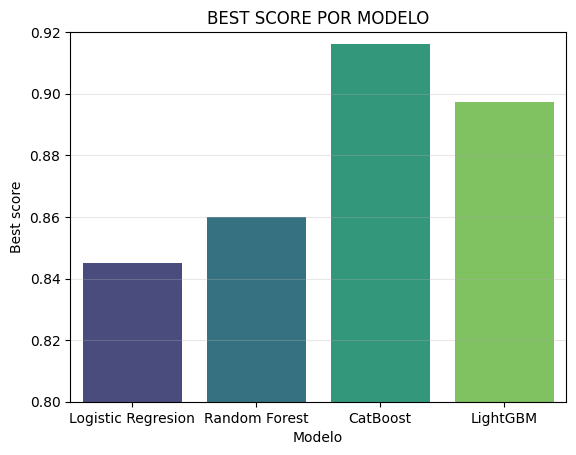

In [88]:
# Unimos los diccionarios en una lista (objeto iterable)
list_res_models = [resultados_lr, resultados_rf, resultados_cb, resultados_lgbm]

# Extraemos los resultados de cada modelo
res_data_models = []

for res in list_res_models:
    for model_name, info in res.items():
        res_data_models.append({'Modelo' : model_name,
                     'Best score' : info['best_score']})
        
df_res_models = pd.DataFrame(res_data_models)

sns.barplot(
    data=df_res_models,
    x='Modelo',
    y='Best score',
    palette='viridis'
)

plt.title('BEST SCORE POR MODELO')
plt.ylim(0.8, 0.92)
plt.grid(axis='y', alpha=0.3)

plt.show()



## **SECCIÓN 6:** *Evaluación Final e Informe de Resultados*

Esta sección corresponde a la evaluación de nuestros modelos con los datos `test`. El propósito de esta función es:

- Comparar el rendimiento en datos que el modelo ya vio (`train`) contra datos totalmente nuevos (`test`). La brecha entre ambos nos indica el nivel de sobreajuste (overfitting).

- Optimización del Umbral de Decisión: Esta función nos ayuda a decidir si el punto de corte debe ser 0.5 o si, para el negocio, nos conviene ser más agresivos.

- Visualización de Métricas immportantes como Matriz de confusión, Feature importance y gráfico de calibración.

Para ello se proponen las siguientes visualizaciones:

- **A. Gráfico de Valor F1 vs. Threshold:**
    - Métrica: El F1-Score es la media armónica entre precisión y exhaustividad (recall).
    - Nos muestrá cómo varía la calidad de la predicción conforme se mueve el umbral de decisión desde 0 hasta 1.
    - El punto más alto de la curva nos indica el umbral óptimo donde el modelo equilibra mejor el no fallar (precisión) con el no dejar escapar a nadie (recall). Si el pico está en 0.4, significa que a partir del 40% de probabilidad ya deberíamos considerar a ese cliente como "en riesgo".

- **B. Curva ROC (Receiver Operating Characteristic):**
    - Métrica: Relaciona la Tasa de Verdaderos Positivos (Sensibilidad) contra la Tasa de Falsos Positivos (1 - Especificidad).
    - Muestra la capacidad del modelo para distinguir entre las dos clases (se va / se queda) en todos los umbrales posibles.
    - Es nuestra métrica principal del proyecto ($AUC ≥ 0.88$). Cuanto más se acerque la curva a la esquina superior izquierda, mejor es nuestra calibración. La línea punteada diagonal representa un modelo que lanza una moneda al aire (puro azar).

- **C. Curva PRC (Precision-Recall Curve):**
    - Relación directa entre Precisión y Recall.
    - Muestra qué tan bueno es el modelo manejando la clase minoritaria (Churn).
    - Buscamos que el área bajo esta curva (Average Precision - AP) sea alta. Si la curva cae bruscamente, significa que para detectar a más clientes que se van, estamos sacrificando demasiada precisión (estamos dando falsas alarmas).

- **D. Matriz de Confusión (Reality Check):**
    - Nos muestra ua tabla de 2x2 con los números crudos: Verdaderos Positivos, Falsos Positivos, Verdaderos Negativos y Falsos Negativos.
    - Es la base de todos las métricas específicas como F1 o AUC-ROC, nos permite decir: *"De 100 personas que se iban, detectamos a 85 (Éxito) pero molestamos por error a 10 que no pensaban irse (Costo operativo)"*.

- **E. Feature Importance (Mapa Estratégico):**
    - Nos muestra un ranking de las variables que más influyeron en las decisiones del modelo.
    - Corresponde con el "Por qué" detrás de los datos. Ejemplo: Si la Fibra Óptica aparece en el top, tenemos la evidencia suficiente para decirle al departamento de infraestructura que revise la estabilidad del servicio o el precio de ese paquete.

- **E. Gráfico de Calibración (Predichos vs. Reales):**
    - Este gráfico divide las predicciones en "cubetas" (bins). Por ejemplo, toma a todos los clientes a los que el modelo les dio un 70% de probabilidad de irse. Si el modelo es perfecto (sigue la línea x=y), exactamente el 70% de esos clientes deberían haberse ido en la realidad.
    - Si la curva verde está por debajo de la línea punteada, el modelo es "optimista" (predice más riesgo del que hay). Si está por arriba, es "pesimista". Esto es vital para que el negocio sepa qué tan confiable es el número de probabilidad que entrega el modelo.

### **6.1 Definiendo la función**

Esta sección corresponde al diseño e implementación de la función `evaluate_model` diseñada como un tablero de control de 3×2.

In [89]:
def evaluate_model(model, train_features, train_target, test_features, test_target, feature_names, threshold=0.5):

    # 1. Configuramos la estructura 3x2
    fig, axs = plt.subplots(3, 2, figsize=(16, 18))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # 2. Definiendo consistencia de colores
    colors = {
        'train' : '#1f77b4',
        'test' : '#2ca02c'
    }

    # 3. === Preparación de predicciones ===
    
    # 3.1 Probabilidades para ambos sets
    proba_train = model.predict_proba(train_features)[:, 1]
    proba_test = model.predict_proba(test_features)[:, 1]
    
    # 3.2 Predicción binaria manual (basada en el parámetro threshold)
    pred_test = (proba_test >= threshold).astype(int)

    # === 4. Bloques A, B y C (Comparativa Train vs. Test) ===
    for label, feat, target, proba in [('train', train_features, train_target, proba_train),
                                      ('test', test_features, test_target, proba_test)]: 
        
        color = colors[label]

        # 4.1 --- (A) F1 vs. Threshold ---
        thresholds = np.linspace(0, 1, 100) # Generamos valores entre 0 y 1 en 100 espacios
        f1_scores = [metrics.f1_score(target, proba >= t) for t in thresholds]

        # Plot principal
        axs[0, 0].plot(thresholds, f1_scores, color=color, label=f'{label} (Max: {max(f1_scores):.2f})')

        # Marcadores F1 (Sincronizados)
        for t_mark in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(thresholds - t_mark))
            marker_color = 'red' if t_mark == threshold else 'orange'
            axs[0, 0].plot(thresholds[closest_value_idx], f1_scores[closest_value_idx],
                          color=marker_color, marker='X', markersize=8)
        
        # 4.2 --- (B) Curva ROC ---
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, proba)
        auc_val = metrics.roc_auc_score(target, proba)

        # Plot principal
        axs[0, 1].plot(fpr, tpr, color=color, label=f'{label} (AUC: {auc_val:.4f})')

        # Marcadores ROC (Sincronizados)
        for t_mark in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - t_mark))
            marker_color = 'red' if t_mark == threshold else 'orange'
            axs[0, 1].plot(fpr[closest_value_idx], tpr[closest_value_idx], 
                           color=marker_color, marker='X', markersize=8)
        
        # 4.3 --- (C) Curva Precision - Recall (PRC) ---
        prec, rec, pr_thresholds = metrics.precision_recall_curve(target, proba)
        ap_val = metrics.average_precision_score(target, proba)

        # Plot principal
        axs[1, 0].plot(rec, prec, color=color, label=f'{label} (AP: {ap_val:.2f})')

        # Marcadores PRC (Sincronizados)
        for t_mark in (0.2, 0.4, 0.5, 0.6, 0.8):
            if t_mark <= max(pr_thresholds): 
                closest_value_idx = np.argmin(np.abs(pr_thresholds - t_mark))
                marker_color = 'red' if t_mark == threshold else 'orange'
                axs[1, 0].plot(rec[closest_value_idx], prec[closest_value_idx], 
                               color=marker_color, marker='X', markersize=8)

    # Ajustes finales Gráfico A
    axs[0, 0].set_title('A. Valor $F_1$ vs. Threshold')
    axs[0, 0].set_xlabel('Threshold')
    axs[0, 0].set_ylabel('$F_1$')
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].legend()

    # Ajustes finales Gráfico B
    axs[0, 1].plot([0, 1], [0, 1], 'k--')
    axs[0, 1].set_title('B. Curva ROC')
    axs[0, 1].set_xlabel('FPR')
    axs[0, 1].set_ylabel('TPR')
    axs[0, 1].grid(True, alpha=0.3)
    axs[0, 1].legend()

    # Ajustes finales Gráfico C
    axs[1, 0].set_title('C. Curva PRC')
    axs[1, 0].set_xlabel('Recall')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].grid(True, alpha=0.3)
    axs[1, 0].legend()

    # === Bloque D: Matriz de confusión (Test) ===
    cm = metrics.confusion_matrix(test_target, pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', ax=axs[1, 1])
    axs[1, 1].set_title(f'D. Matriz de Confusión (Test - Threshold {threshold})')
    axs[1, 1].set_xlabel('Predicción')
    axs[1, 1].set_ylabel('Real')

    # === Bloque E: Feature Importance ===
        # Nota: Ajuste especial para cada tipo de modelo
    if hasattr(model, 'get_feature_importance'): # CatBoost
        importances = model.get_feature_importance()
    elif hasattr(model, 'feature_importances_'): # RF / LGBM
        importances = model.feature_importances_
    else: # Logistic Regression
        importances = np.abs(model.coef_[0])

    fi_df = pd.DataFrame({'feat' : feature_names, 'imp' : importances}).sort_values('imp', ascending=False).head(10)
    sns.barplot(x='imp', y='feat', data=fi_df, palette='viridis', ax=axs[2,0])
    axs[2, 0].set_title('E. Top 10 Feature Importance')
    axs[2, 0].set_xlabel('Importance')
    axs[2, 0].set_ylabel('Variable')
    axs[2, 0].grid(True, axis='x', alpha=0.3)

    # Bloque F: Predichos vs. Reales (Calibration Plot)
    prob_true, prob_pred = calibration_curve(test_target, proba_test, n_bins=10)
    axs[2, 1].plot(prob_pred, prob_true, marker='s', label='Model', color=colors['test'])
    axs[2, 1].plot([0, 1], [0, 1], 'k--', label='Calibración perfecta ($x=y$)')
    axs[2, 1].set_title('F. Calibración: Predichos vs. Reales')
    axs[2, 1].set_xlabel('Probabilidad predicha')
    axs[2, 1].set_ylabel('Fracción Real de Positivos')
    axs[2, 1].grid(True, alpha=0.3)
    axs[2, 1].legend()

    plt.show()

### **6.2 Evaluando los modelos y resultados**

En esta sección someteremos nuestros modelos finales a una evaluación de rendimiento, recordar que cada modelo es el mejor seleccionado dentro de su categoría. Nos enfocaremos en evaluar nuestros modelos en el conjunto Test, el objetivo no es solo encontrar el score más alto, sino entender el "comportamiento" de cada algoritmo frente al desbalance del Churn.

- Para cada modelo, generaremos un tablero de control que nos permitirá realizar un diagnóstico de 360 grados:
    - Rendimiento y Umbrales: A través de las curvas F1 vs. Threshold, ROC y PRC, mediremos la capacidad del modelo para separar clientes y encontraremos el punto de corte óptimo para el negocio.
    - Impacto Real: Con la Matriz de Confusión, traduciremos las probabilidades en números de clientes capturados y fugas no detectadas.
    - Explicabilidad: El Feature Importance nos dirá qué variables están influyendo en nuestro modelo.
    - Honestidad Matemática: La Curva de Calibración nos confirmará si las probabilidades predichas son realistas o si el modelo está siendo demasiado alarmista.

- Tenemos 4 modelos a evaluar:
    1. Regresión Logística: Nuestro baseline lineal. ¿Es suficiente la simplicidad para un nuestro problema?
    2. Random Forest: El bosque de decisión. ¿Logra capturar las interacciones no lineales que la regresión ignoró?
    3. CatBoost: El líder actual con 0.9162. Veremos si su manejo nativo de categorías mantiene esa precisión en el set de prueba.
    4. LightGBM: ¿Podrá competir en precisión con CatBoost ofreciendo una mayor eficiencia operativa?

---

#### **6.2.1 Evaluando modelo de Regresión Logística:** `eval_lr`

La Regresión Logística corresponde a nuestro punto de partida, es importante aclarar que no se esperan resultados contundentes para este modelo pero el manejo simple de la RL nos presentará un resltado honesto respecto a lo que podemos mejorar en modelos posteriores.

C:\Users\rockz\AppData\Local\Temp\ipykernel_34768\834574187.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='imp', y='feat', data=fi_df, palette='viridis', ax=axs[2,0])


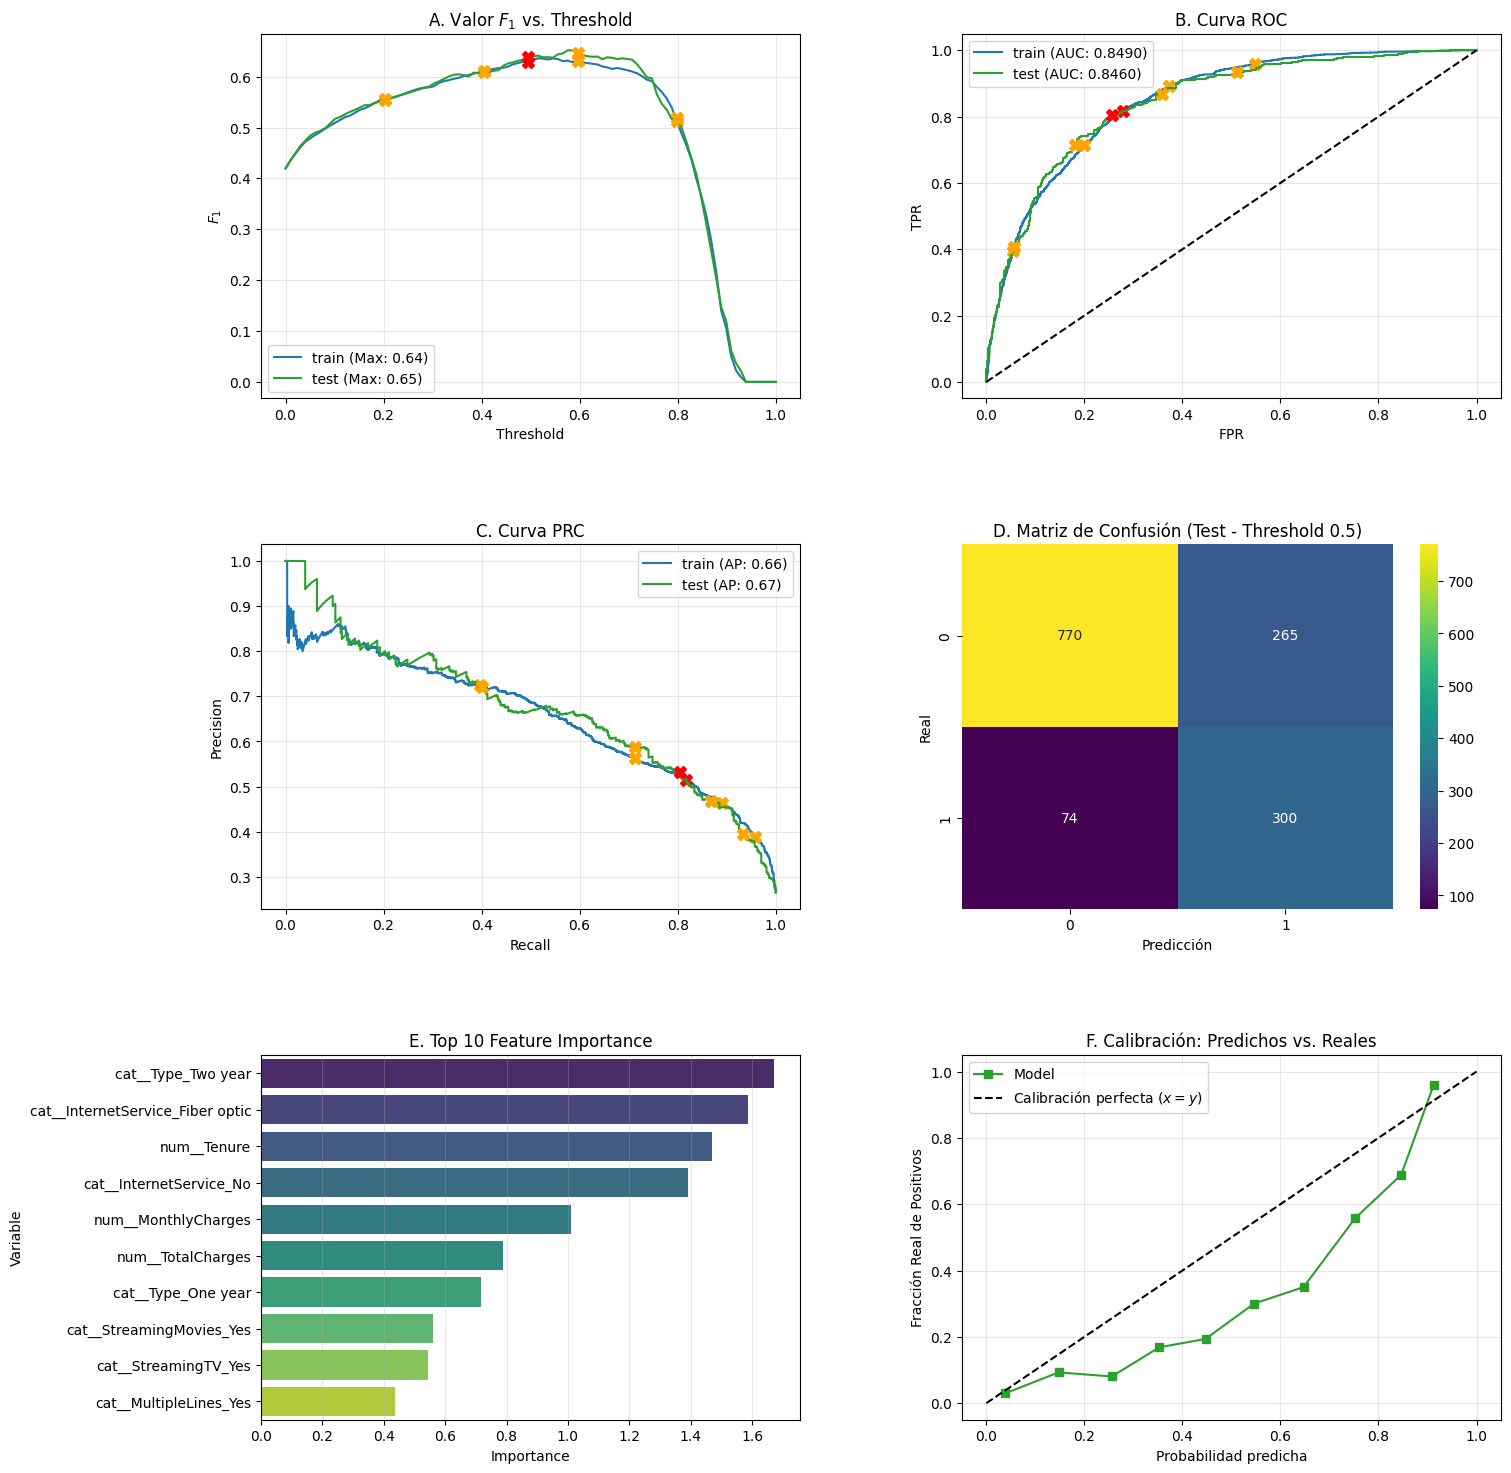

In [90]:
eval_lr = evaluate_model(
    model=resultados_lr['Logistic Regresion']['best_model'],
    train_features=X_train_linear,
    train_target=y_train,
    test_features=X_test_linear,
    test_target=y_test,
    feature_names=X_train_linear.columns
)

**Comentarios:**

- **A) Valor F1 vs. Threshold:**
    - Las curvas train y test están prácticamente solapadas, esto nos ayuda a confirmar que el modelo generaliza perfectamente.
    - Hemos alcanzado un Max F1 de 0.65 en Test.
    - Sabiendo que nuestro umbral se encuentra en 0.5, la "X" roja está situada casi en la cima de la curva. Esto indica que, para este modelo lineal, el umbral estándar de 0.5 es el punto óptimo de equilibrio entre precisión y recall.

- **B) Curva ROC (Métrica Objetivo):**
    - El AUC de 0.8460 en prueba es muy consistente con el 0.8490 de entrenamiento.
    - En este punto inicial, nos encontramos a solo 0.034 puntos de la meta establecida de 0.88. La curva es suave y con un "codo" bien definido, lo que indica que el modelo tiene una buena capacidad de ordenamiento, pero le falta la potencia no lineal que probablemente aportarán los árboles.

- **C) Curva PRC:**
    - La curva se mantiene por encima de 0.8 de precisión hasta que el recall llega a 0.2.
    - A partir de ahí, la precisión cae de forma constante para ganar recall.
    - Esto sugiere que el modelo identifica con mucha seguridad a un grupo pequeño de clientes, pero duda más conforme queremos atrapar a la masa crítica de desertores.

- **D) Matriz de confusión (Threshold a 0.5):**
    - Recall (Sensibilidad): De los 374 cleintes que se iban $(300(TP) + 74(FN))$, el modelo detectó $300$. Esto corresponde al $80.21\%$ de efectividad para tetectar los chunrs.
    - Precisión: De las 565 alarmas de churn que se dieron $(300(TP) + 265(FP))$, solo $300$ eran reales $(53\%)$.
    - Tenemos muchas "falsas alarmas" (265 Falsos Positivos). Si cada promoción de retención es cara, este modelo podría estar gastando presupuesto innecesario en gente que no pensaba irse.

- **E) Top 10 Feature Importance:**
    - Las variables de Tipo de Contrato (Two year) y Servicio de Internet (Fiber optic) dominan la escena.
    - Esto confirma la hipótesis de que la tecnología de fibra óptica es un predictor crítico en el análisis de riesgo.

- **F) Calibración: Predichos vs. Reales:**
    - El modelo es Sobre-confiado (Overconfident).
    - La línea verde está casi siempre por debajo de la línea punteada negra.
    - Cuando el modelo dice que un cliente tiene un 80% de riesgo, en la realidad el riesgo es de aproximadamente 60-70%. El modelo está siendo un poco "alarmista" con sus probabilidades.

---

#### **6.2.2 Evaluando modelo Random Forest:** `eval_rf`

Procedemos con el modelo Random Forest, se espera un incremento en las métricas debido al poder manejo de datos no lineales. Mientras que la Regresión Logística era un modelo sencillo y honesto, el Bosque Aleatorio es más complejo y tiende a ser un poco más "optimista" con sus propios aciertos.

C:\Users\rockz\AppData\Local\Temp\ipykernel_34768\834574187.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='imp', y='feat', data=fi_df, palette='viridis', ax=axs[2,0])


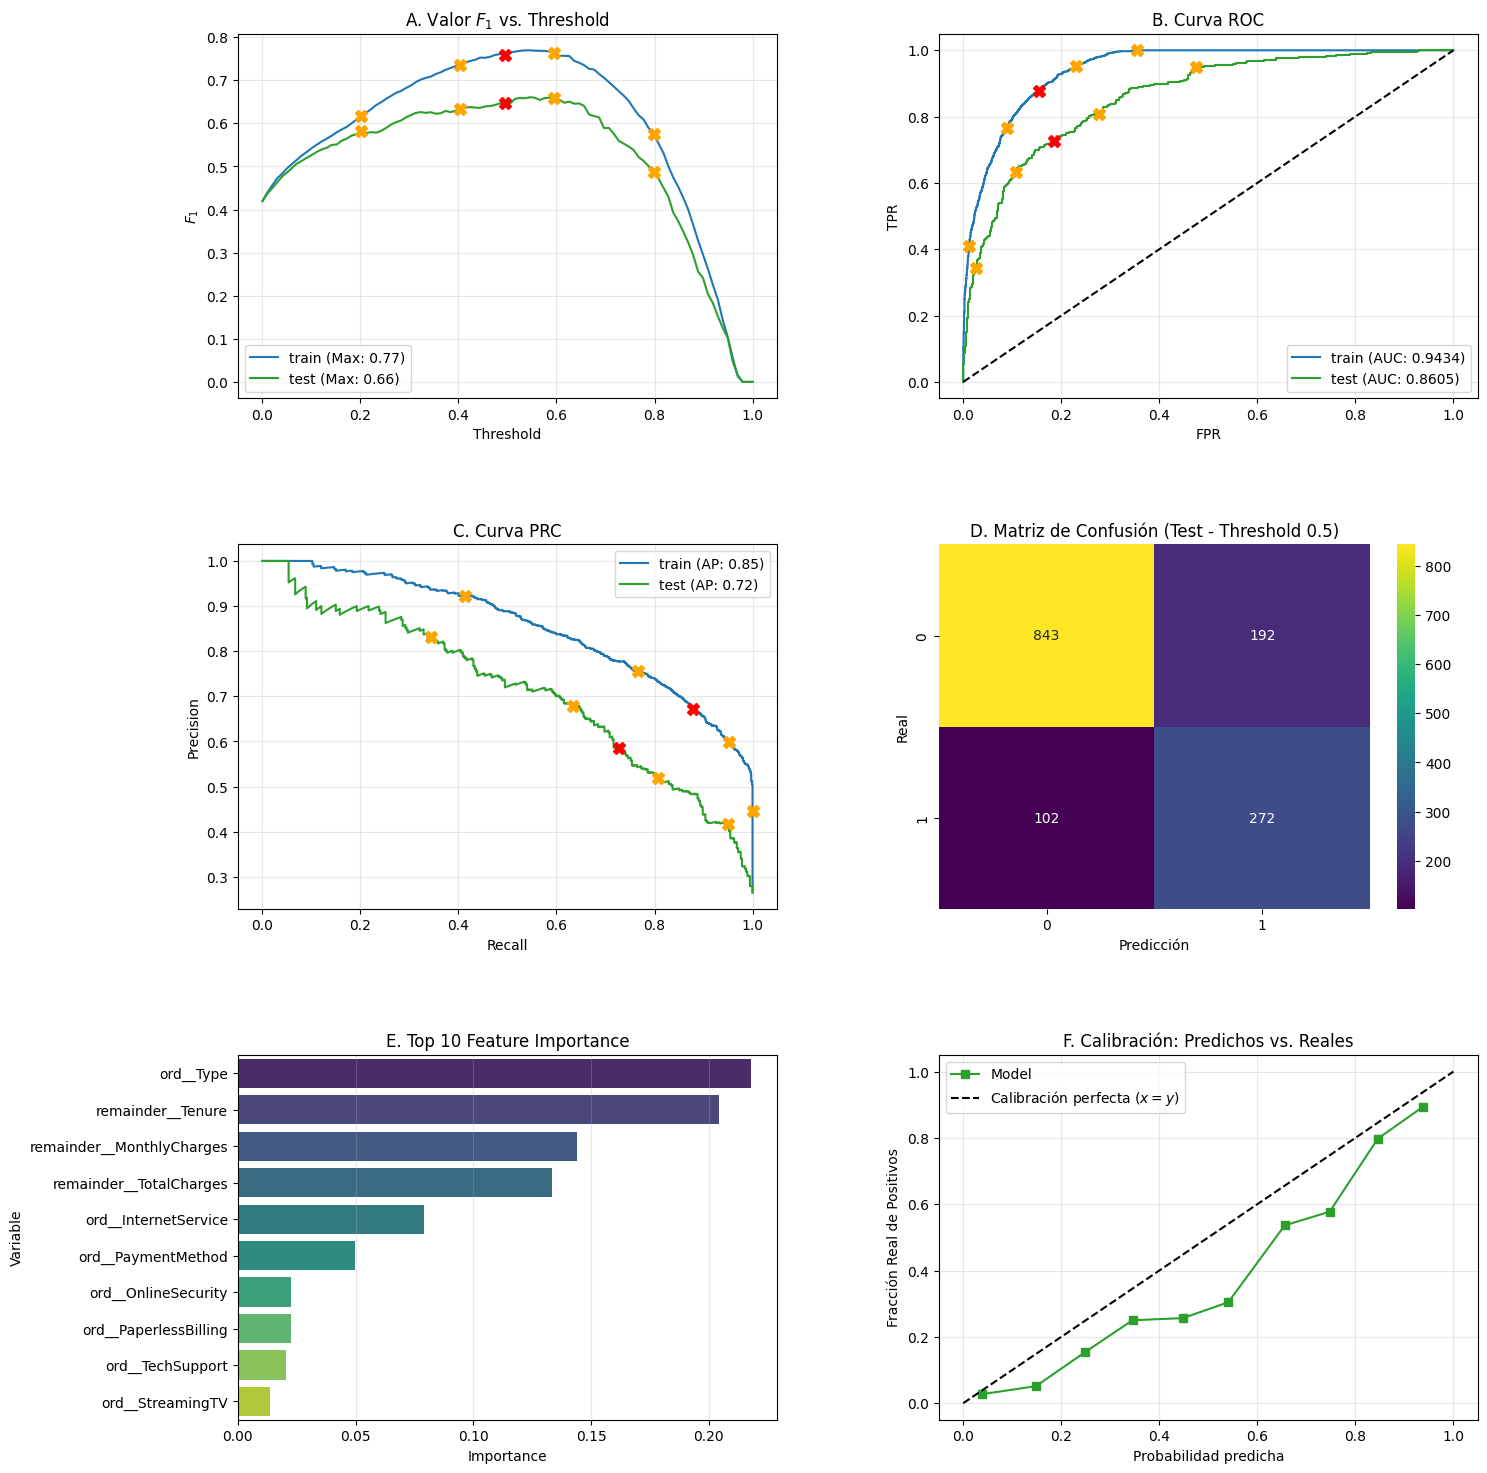

In [91]:
eval_rf = evaluate_model(
    model=resultados_rf['Random Forest']['best_model'],
    train_features=X_train_rf,
    train_target=y_train,
    test_features=X_test_rf,
    test_target=y_test,
    feature_names=X_train_rf.columns
)

**Comentarios:**

- **A) Valor F1 vs. Threshold:**
    - Podemos observar una ligera separación entre la curva azul (Train) respecto a la curva verde (Test).
    - El Max F1 en entrenamiento es 0.77, mientras que en prueba es 0.66.
    - Esta es una señal clara de overfitting (sobreajuste). El modelo memorizó patrones específicos de los datos de entrenamiento que no se repiten con la misma intensidad en el test.
    - El mejor balance para el negocio se alcanza en un umbral de 0.6 (donde la curva verde llega a su pico), un poco más arriba del estándar 0.5.

- **B) Curva ROC (Métrica Objetivo):**
    - Hemos subido el AUC a 0.8605 en el set de prueba.
    - Es una mejora respecto al 0.8460 de LR. Estamos mucho más cerca del objetivo de 0.88.
    - Las diferencias (Train: 0.94 vs Test: 0.86) confirman que el modelo es muy potente, pero quizás demasiado reservado con los datos que no conoce.

- **C) Curva PRC:**
    - El Average Precision (AP) subió a 0.72 (frente al 0.67 de LR).
    - El modelo es mejor identificando a los desertores reales sin mezclarlos tanto con los clientes leales. La curva se mantiene más alta en la esquina superior izquierda.

- **D) Matriz de confusión (Threshold a 0.5):**
    - Las falsas alarmas bajaron de 265 (LR) a 192.
    - Verdaderos Positivos (Capturados): Bajaron de 300 (LR) a 272.
    - El modelo es más conservador. Prefiere no dar tantas falsas alarmas, aunque eso signifique que 102 clientes (Falsos Negativos) se le escapen sin ser detectados.

- **E) Top 10 Feature Importance:**
    - Para este modelo, el Tipo de Contrato es, por mucho, la variable más importante.
    - Le siguen la Antigüedad (Tenure) y los Cargos Mensuales.
    - El Random Forest detectó que el contrato es más decisivo que la tecnología (Internet Service), dándole un enfoque más contractual que técnico al problema del Churn.

- **F) Calibración: Predichos vs. Reales:**
    - Sigue siendo un modelo Sobre-confiado, pero con una curva más inestable.
    - Para probabilidades bajas (0.2 - 0.4), el modelo es bastante honesto. Sin embargo, cuando predice riesgos altos (0.6 - 0.8), la realidad está muy por debajo de su predicción.

---

**Recomendaciones para el modelo:**

El 0.8605 en el set de prueba es un avance real, pero el 0.9434 en entrenamiento nos está indicando que el bosque está "memorizando" los datos de entrenamiento en lugar de entender el comportamiento general de los clientes. Aunque el `max_depth=10` ayudó, no fue suficiente para detener el sobreajuste. El modelo sigue creando ramas demasiado específicas.

1. Optimización del Umbral (Threshold): A partir de la gráfica A. Valor F1 vs. Threshold podemos observar:
    - El F1 Max en el set de prueba no ocurre en el umbral estándar de 0.5, sino cerca de 0.6.
    - Si el negocio pide maximizar el balance entre precisión y recall, debemos proponer que un cliente se considere "en riesgo" solo si su probabilidad es mayor a 0.6. Esto reducirá automáticamente tus 192 Falsos Positivos.

2. Mas estrictos con Regularización (Control de Crecimiento)
    - Introducir `min_samples_leaf`: Este parámetro es el más importante para evitar el sobreajuste en RF.
    - Aumentar `min_samples_split`: Esto detiene el crecimiento del árbol mucho antes de que se vuelva demasiado complejo. Ya usamos 10, pero podríamos probar con valores más agresivos como 20 o 30.
    - Reducir `max_features`: Probar con un valor menor (ejemplo. 0.2 o 0.3), esto obliga a los árboles a ser más diferentes entre sí, lo que suele mejorar la generalización del bosque completo.

3. Ajustes de Bootstrapping: Por defecto, cada árbol del Random Forest intenta usar todo el dataset (con reemplazo).
    - Limitar el parámetro `max_samples` a un valor como 0.7 o 0.8.
    - Cada árbol solo verá el 70% de los datos.
    - Esto introduce más aleatoriedad y diversidad en el bosque, lo que ayuda enormemente a reducir la varianza.

---

#### **6.2.3 Evaluando modelo CatBoost:** `eval_cb`

Se espera que con este modelo se llegue a la meta debido a su capacidad de manejo de datos categóricos, inclusive de forma nativa.

C:\Users\rockz\AppData\Local\Temp\ipykernel_34768\834574187.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='imp', y='feat', data=fi_df, palette='viridis', ax=axs[2,0])


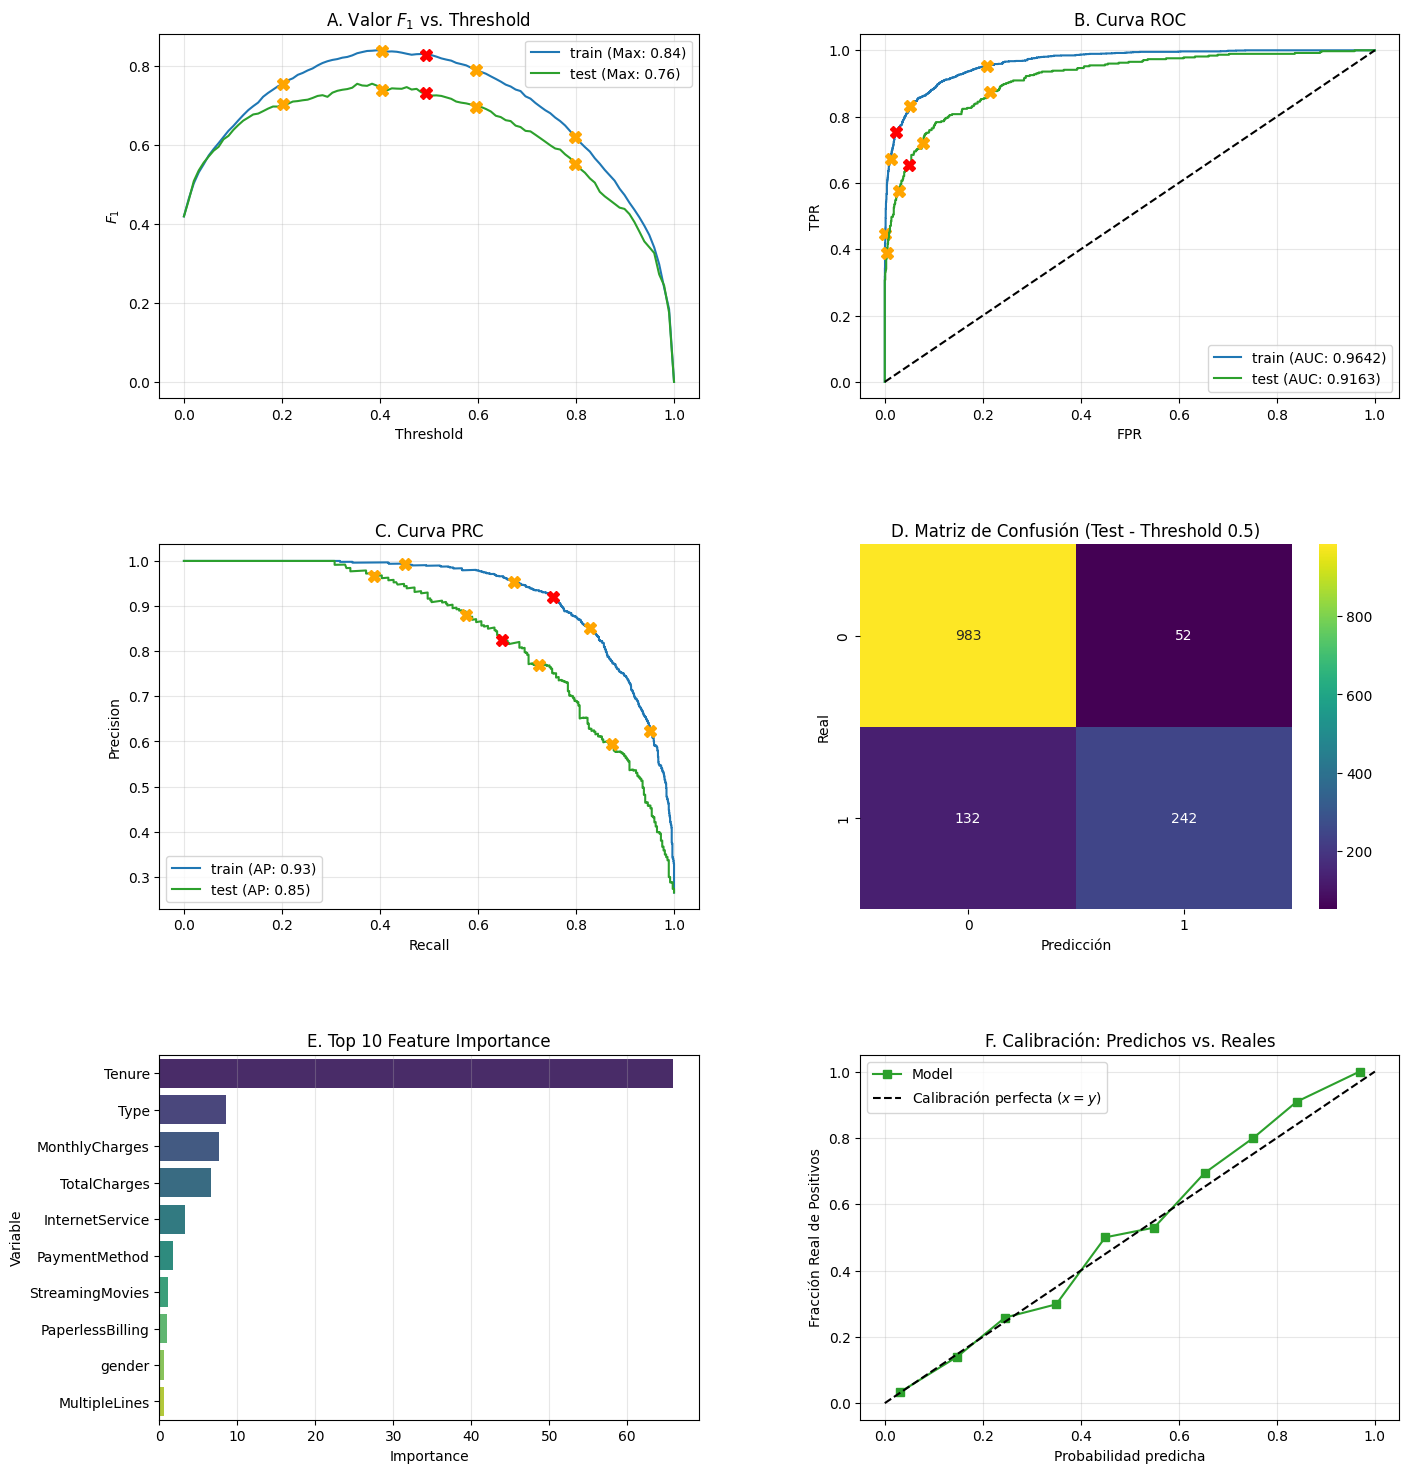

In [92]:
eval_cb = evaluate_model(
    model=resultados_cb['CatBoost']['best_model'],
    train_features=X_train,
    train_target=y_train,
    test_features=X_test,
    test_target=y_test,
    feature_names=X_train.columns
)

**Comentarios:**

- **A) Valor F1 vs. Threshold:**
    - Hemos logrado un Max F1 de 0.76 en Test superando por 10 puntos a la Regresión Logística (0.65) y al Random Forest (0.66).
    - El pico de la curva se encuentra cerca del umbral 0.4. Esto sugiere que para maximizar el balance entre detectar desertores y no dar falsas alarmas, el negocio debería ser un poco más sensible de lo normal.

- **B) Curva ROC (Métrica Objetivo):**
    - Hemos sobrepasado por mucho la métrica objetivo, logrando un AUC de 0.9163 en el conjunto de prueba.
    - La curva muestra un "codo" extremadamente agresivo hacia la esquina superior izquierda, indicando una capacidad de ordenamiento de riesgo superior.
    - Aunque existe una brecha (Train 0.96 vs Test 0.91), es mucho más sana que la del Random Forest.
    - CatBoost no solo "memorizó" mejor, sino que lo que aprendió fue mucho más útil para los datos nuevos

- **C) Curva PRC:**
    - Un Average Precision (AP) de 0.85.
    - A diferencia de los modelos anteriores, CatBoost mantiene una precisión altísima (cercana al 1.0) incluso cuando el Recall ya ha avanzado hasta el 0.3. Esto significa que el modelo puede identificar al primer 30% de los desertores con cero errores.

- **D) Matriz de confusión (Threshold a 0.5):**
    - La eficiencia ha mejorado, solo 52 falsos positivos (falsas alarmas), una reducción drástica comparada con los 192 de RF y los 265 de LR.
    - El modelo logra capturar a $242(TP)$ desertores reales con una limpieza operativa eficiente. El costo de "molestar" a clientes leales es ahora mínimo para el negocio ($52(FP)$).

- **E) Top 10 Feature Importance:**
    - Mientras que en LR y RF la importancia estaba repartida, en CatBoost la Antigüedad (Tenure) es la reina absoluta con un peso cercano a 65.
    - El modelo descubrió que el tiempo que un cliente lleva en la compañía es el factor más determinante para su lealtad, mucho más que el tipo de contrato o el precio.

- **F) Calibración: Predichos vs. Reales:**
    - Es, por mucho, el modelo mejor calibrado.
    - La línea verde sigue casi perfectamente la diagonal punteada. Si el modelo dice que un cliente tiene un 60% de riesgo, podemos llevar ese dato a un concepto acertado: la probabilidad es real y no una exageración algorítmica.
    - Random Forest era muy sobre-confiado (alarmista). CatBoost es honesto. Para el negocio, esto significa que los scores de riesgo pueden usarse directamente para calcular el ROI de las campañas sin necesidad de ajustes manuales.

---

**Recomendaciones para el modelo:**

Aunque ya contamos con un modelo extremadamente sólido que ya superó con creces la meta del proyecto, podemos hacer ciertas recomendaciones mínimas:

1. Ajuste Estratégico de Umbrales (Threshold): Actualmente, el modelo opera por defecto en 0.5, pero los datos sugieren un movimiento mínimo.
    - Mover el umbral a 0.4.
    - En la gráfica de F1, el punto máximo de balance ocurre en 0.4 (Max: 0.76).
    - Al bajar el umbral a 0.4, el modelo será más sensible para detectar fugas. Con esto lograremos reducir esos 132 Falsos Negativos (clientes que se van sin aviso), lo cual es financieramente más valioso que el pequeño incremento que podríamos tener en falsas alarmas.

2. Recomendaciones para el Modelo (Hiperparámetros): `depth: 4` ya es en sí mismo excelente para evitar el sobreajuste, pero la brecha entre el 0.96 de entrenamiento y el 0.91 de prueba indica que todavía podemos inyectar un poco más de robustez:
    - Aumentar `l2_leaf_reg`: Actualmente el modelo maneja un valor de 1. Probar con valores más altos (como 3, 5 o 10) obligará al modelo a ser más conservador en la estructura de sus árboles, ayudando a cerrar esa brecha de 5 puntos entre Train y Test.
    - Uso de `early_stopping_rounds = 50`, esto detendrá el entrenamiento en el momento exacto en que el error de validación deje de bajar, protegiendo al modelo de overfitting.
    - Reducción del `learning_rate`: Podríamos probar bajar de 0.1 a 0.05 o 0.01, aumentando proporcionalmente las iterations. Esto hace que el aprendizaje sea más lento pero mucho más preciso y estable.

---

#### **6.2.4 Evaluando modelo Light GBM:** `eval_lgbm`

Este tipo de modelo está centrado en la eficiencia, y, aunque no se esperan resultados superiores a CatBoost, si pueden ser competitivos respecto al tiempo de entrenamiento y la calidad en las métricas.

C:\Users\rockz\AppData\Local\Temp\ipykernel_34768\834574187.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='imp', y='feat', data=fi_df, palette='viridis', ax=axs[2,0])


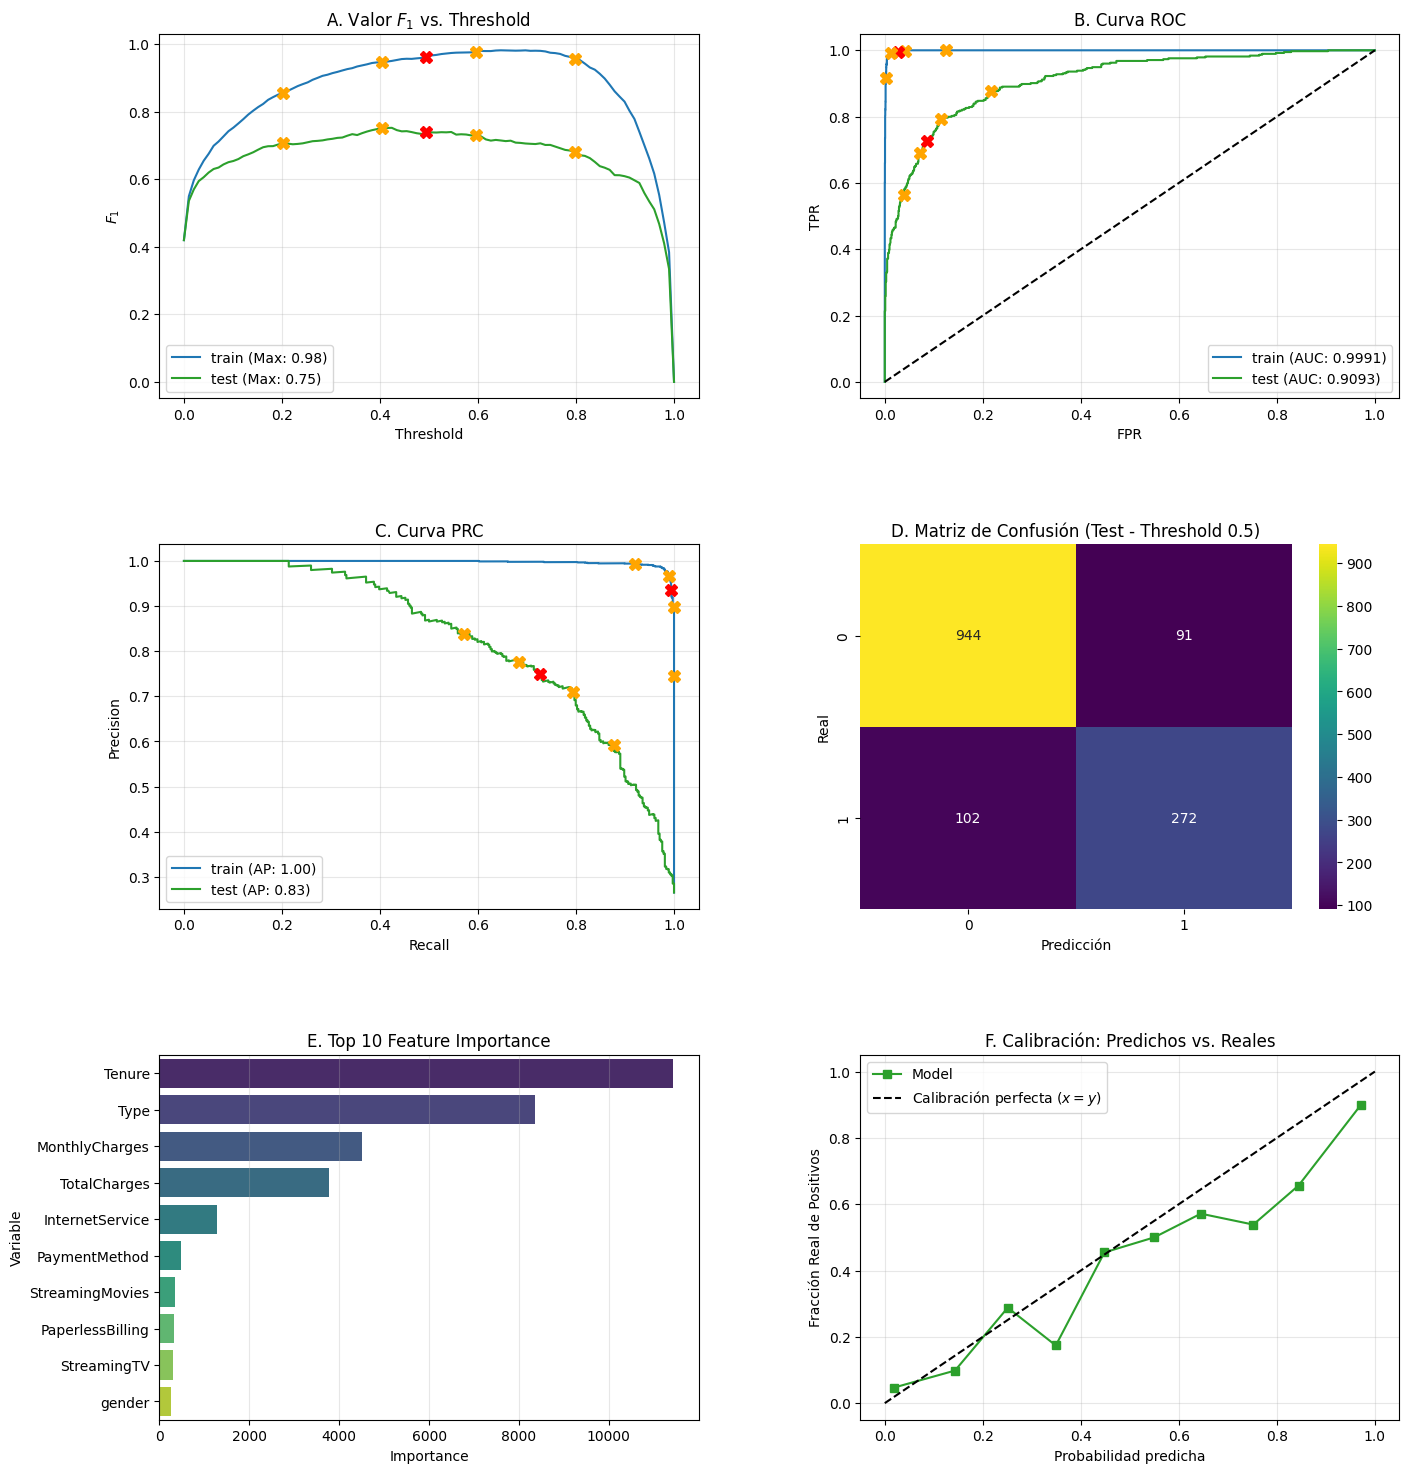

In [93]:
eval_lgbm = evaluate_model(
    model=resultados_lgbm['LightGBM']['best_model'],
    train_features=X_train_lgb,
    train_target=y_train,
    test_features=X_test_lgb,
    test_target=y_test,
    feature_names=X_train_lgb.columns
)

**Comentarios:**

A priori, este modelo se presenta como un competidor bastante efectivo que ha logrado superar con creces la meta de 0.88 AUC-ROC. Sin embargo, a diferencia de la estabilidad casi precisa que vimos en CatBoost, este modelo muestra una "voracidad" por los datos de entrenamiento que debemos vigilar de cerca para evitar el sobreajuste.

- **A) Valor F1 vs. Threshold:**
    - El modelo alcanza un Max F1 de 0.75 en el set de prueba. No obstante, existe una brecha masiva con el entrenamiento (0.98), lo que indica que el modelo "memorizó" casi perfectamente el set de entrenamiento.
    - El punto óptimo de decisión se mantiene cerca de un umbral de 0.4.

- **B) Curva ROC (Métrica Objetivo):**
    - Hemos obtenido un AUC de 0.9093 en prueba. Es un resultado excelente, aunque el 0.9991 en entrenamiento confirma un overfitting severo. El modelo es casi "perfecto" en el papel, pero pierde un 9% de esa precisión al enfrentarse a datos nuevos.

- **C) Curva PRC:**
    - El Average Precision (AP) de 0.83 es muy alto. Esto significa que el modelo es sumamente confiable para identificar a los clientes con mayor riesgo de fuga antes de que su precisión comience a degradarse.
    - Existe una brecha entre los datos de entrenamiento con un resultado perfecto de 1 respecto a los resultados de entrenamiento, nuevamente se confirma el overfitting.

- **D) Matriz de confusión (Threshold a 0.5):**
    - Verdaderos Positivos (TP): 272. Atrapó a más clientes en riesgo que CatBoost (242) bajo el mismo umbral.
    - Falsas Alarmas (FP): 91. Es más alarmista que CatBoost (52), pero mucho más eficiente que los modelos iniciales.

- **E) Top 10 Feature Importance:**
    - Al igual que en los modelos anteriores de ensamble, Tenure (antigüedad) y Type (tipo de contrato) son los pilares fundamentales que dictan el comportamiento del Churn.

- **F) Calibración: Predichos vs. Reales:**
    - El modelo muestra ligeras oscilaciones. Tiende a ser un poco subestimador en el rango de probabilidad de 0.3 a 0.4 (la línea verde está por encima de la negra), pero el modelo es Sobre-confiado (Overconfident) en términos generales.

---

**Recomendaciones para el modelo:**

Hemos de tener en cuenta que nuestro modelo ha memorizado los datos, esto queda demostrado en 0.9991 en entrenamiento frente al 0.9093 en prueba.

1. Limitar la Complejidad del Árbol: El parámetro más importante en LightGBM es `num_leaves`. Actualmente el modelo maneja 31 (el estándar), pero con una profundidad de 10, el modelo tiene demasiada libertad para crear ramas muy específicas.
    - Reducir `num_leaves`: Se sugiere probar con valores entre 10 y 25. Esto obligará al modelo a simplificar sus decisiones.
    - Reducir `max_depth`: Un valor de 5 o 7 suele ser suficiente para capturar patrones de negocio sin caer en el ruido.
    - Aumentar `min_data_in_leaf`: Este es vital. Si lo subimos a 50 o 100, evitaremos que el modelo cree hojas para grupos de clientes muy pequeños.

2. Fortalecer la Regularización: Los valores actuales de `reg_alpha` (0.5) y `reg_lambda` (0.1) son muy tímidos para un caso de sobreajuste severo.
    - Subir `reg_lambda` (L2): Prueba con valores de 1, 5 o incluso 10. Esto penaliza los coeficientes grandes y suaviza el modelo.
    - Subir `reg_alpha` (L1): Ayuda a que las variables menos importantes (el "ruido") tengan un peso de cero, simplificando el modelo automáticamente.

3. Inyectar Aleatoriedad (Sampling): Si el modelo ve todos los datos y todas las variables en cada paso, encontrará formas de caer en overfitting.
    - `feature_fraction`: Hemos de configurarlo en 0.7 u 0.8. Esto obliga al modelo a usar solo una parte de las columnas en cada iteración.
    - `bagging_fraction` y `bagging_freq`: Hemos de usar un valor de 0.7 para el primero y 5 para el segundo. Esto hará que cada árbol se entrene con una muestra aleatoria de clientes, mejorando la robustez general.

4. Control del Entrenamiento
    - Reducir `learning_rate`: Baja de 0.1 a 0.01.
    - Implementar `early_stopping_rounds`: En lugar de dejar que llegue a los 500 estimadores, podemos detener el proceso en el momento exacto en que el error en el set de validación deje de bajar.

---

### **6.3 Ronda de mejoras:** - *Evaluando los modelos y resultados*

Tras el diagnóstico exhaustivo de la sección anterior, hemos pasado de entender el rendimiento a identificar las "fugas de precisión" en nuestros algoritmos. 

Descartamos la Regresión Logística en esta etapa; cumplió su misión como nuestro "piso" o baseline, demostrando que un enfoque lineal es estable pero insuficiente para capturar la complejidad del comportamiento de los clientes.

Este es el contexto de cada modelo.

1. Random Forest (RF): Cerrando la brecha de varianza
    - El diagnóstico mostró un modelo que "memoriza" demasiado. Nuestra misión aquí es endurecer las restricciones de crecimiento (regularización) para obligar al bosque a aprender patrones generales y no casos aislados.

2. CatBoost (CB): El ajuste del modelo con mejor desempeño
    - Aunque ya es nuestro modelo líder con un 0.9163, buscaremos ese punto de afinidad optimizando el Umbral de Decisión (Threshold) a 0.4 y explorando una regularización L2 más agresiva para pulir su ya excelente calibración.

3. LightGBM (LGB): Cirugía contra el Overfitting
    - Es el modelo con el caso más severo de sobreajuste (0.99 en train vs. 0.90 en test). Aquí las acciones serán drásticas: reduciremos la complejidad de sus hojas y aumentaremos la aleatoriedad en la selección de datos y variables para "obligarlo" a ser más preciso.
  
---

#### **6.3.1 Implementaciones en Random Forest:** `task_rf_tuned_v1`

Aplicamos las mejoras propuestas a los hiperparámetros.

In [94]:
# Tarea de entrenamiento para RF

task_rf_tuned_v1 = {
    'name' : 'Random Forest Tuned V1',
    'model' : RandomForestClassifier(
        random_state=230598,
        class_weight='balanced',
        n_jobs=-1
    ),
    'X_train' : X_train_rf,
    'params' : {
        'n_estimators': [200, 300],
        'max_depth': [5, 8, 10], # Reducimos profundidad para evitar ramas ultra-específicas
        'min_samples_split': [20, 30, 40], # Más agresivo (antes 2-10) para detener el crecimiento temprano
        'min_samples_leaf': [10, 20, 30], # Asegura que cada hoja tenga una base sólida de clientes
        'max_features': [0.2, 0.3], # Forzamos a que los árboles sean más diversos entre sí
        'max_samples': [0.7, 0.8] # Cada árbol solo ve una fracción de los datos para reducir la varianza
    },
    'search_type' : 'grid'
}

In [95]:
resultados_rf_tuned_v1 = run_model_optimization([task_rf_tuned_v1], y_train)

Optimazing Random Forest Tuned V1...


In [96]:
# Tenemos los resultados de RF
for model_name, model_info in resultados_rf_tuned_v1.items():
    print("-" * 80)
    print(f"Modelo: {model_name}")
    print(f"  ➤ Mejor score: {model_info['best_score']:.4f}")
    print(f"  ➤ Mejor modelo: {model_info['best_model']}")
    print(f"  ➤ Mejores parámetros: {model_info['best_params']}")
    print(f"  ➤ Tiempo de ajuste: {model_info['fit_time']:.2f} segundos")
    print("-" * 80)

--------------------------------------------------------------------------------
Modelo: Random Forest Tuned V1
  ➤ Mejor score: 0.8606
  ➤ Mejor modelo: RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=0.3,
                       max_samples=0.8, min_samples_leaf=10,
                       min_samples_split=20, n_estimators=200, n_jobs=-1,
                       random_state=230598)
  ➤ Mejores parámetros: {'max_depth': 8, 'max_features': 0.3, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 200}
  ➤ Tiempo de ajuste: 146.01 segundos
--------------------------------------------------------------------------------


C:\Users\rockz\AppData\Local\Temp\ipykernel_34768\834574187.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='imp', y='feat', data=fi_df, palette='viridis', ax=axs[2,0])


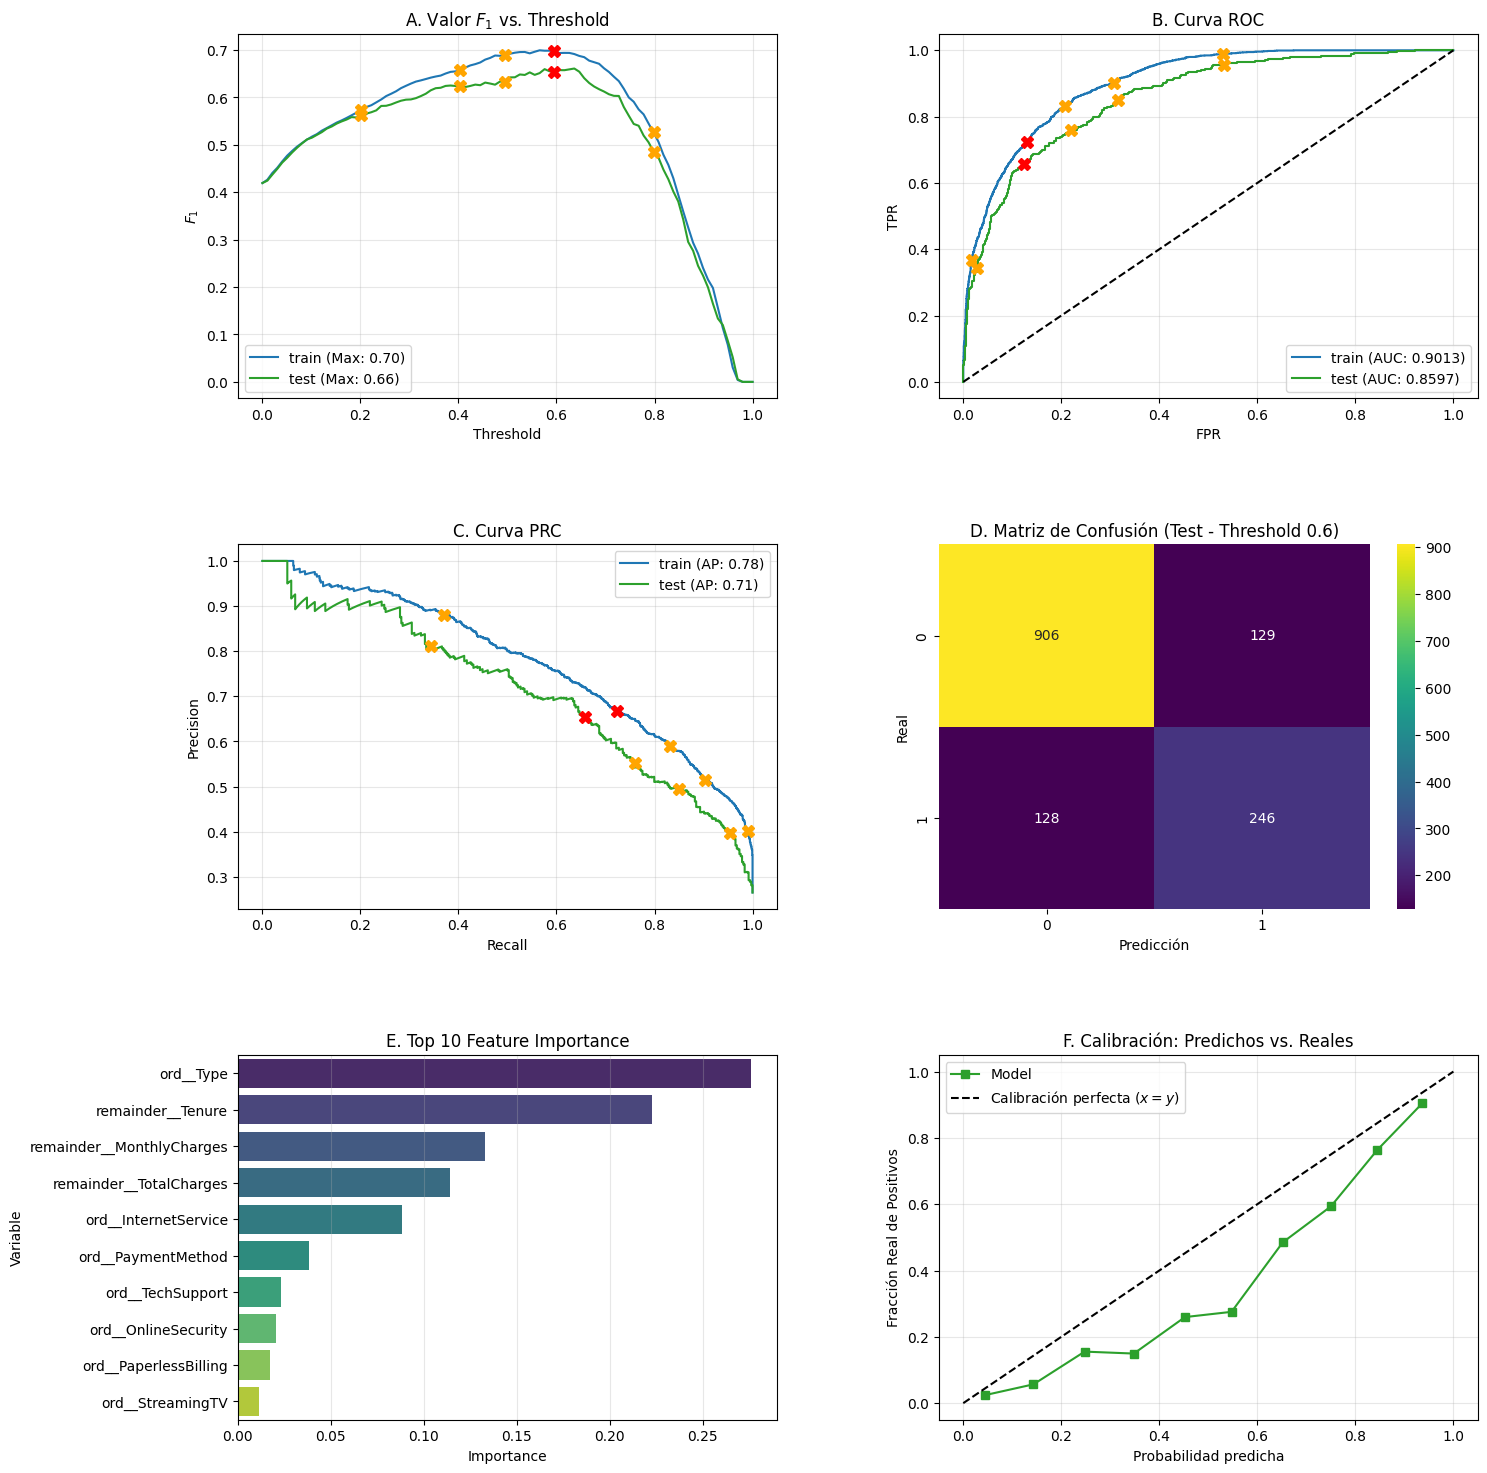

In [97]:
eval_rf_tuned_v1 = evaluate_model(
    model=resultados_rf_tuned_v1['Random Forest Tuned V1']['best_model'],
    train_features=X_train_rf,
    train_target=y_train,
    test_features=X_test_rf,
    test_target=y_test,
    feature_names=X_train_rf.columns,
    threshold=0.6
)

**Comentarios:**

Los resultados de la tarea `task_rf_tuned_v1` demuestran que hemos logrado el objetivo principal: transformar un modelo que memorizaba en un modelo que entiende mejor los datos. Aunque el score de AUC en prueba se mantuvo casi idéntico, la salud estructural del modelo ha mejorado drásticamente.

- Random Forest (Original):
    - AUC (Train) --> 0.9434
    - AUC (Test) --> 0.8605
    - Brecha (GAP) --> 0.0829
    - Falsos Positivos (FP) --> 192
    - Verdaderos Positivos (TP) --> 272

- Random Forest Tuned V1 (Umbral 0.6):
    - AUC (Train) --> 0.9013 (-4.2% (Menos Overfitting))
    - AUC (Test) --> 0.8597
    - Brecha (GAP) --> 0.0416 (Reducción de casi 50% de la brecha)
    - Falsos Positivos (FP) --> 129
    - Verdaderos Positivos (TP) --> 246

**Mejoras:**

- Al reducir la profundidad máxima a `max_depth=8` y aumentar el `min_samples_split=20`, hemos obligado al bosque a ignorar el ruido de clientes individuales.

- Al mover el umbral a 0.6, hemos eliminado 63 falsas alarmas (de 192 a 129).
    - Para reducir las falsas alarmas en un 32%, aceptamos que se nos escapen 26 clientes adicionales (de 102 a 128 Falsos Negativos).

- Gráfico A (F1 vs Threshold): en la versión Tuned, las curvas de `train` y `test` están mucho más cerca una de la otra. Esto nos da la seguridad de que el modelo se comportará de la misma forma cuando lo lancemos a producción con datos nuevos.

- Respecto al gráfico de calibración, la línea verde en la versión Tuned está ligeramente más cerca de la diagonal en los rangos medios. El modelo ahora es un poco más "honesto" con sus probabilidades, aunque todavía tiende a ser ligeramente sobre-confiado en el extremo superior.

- Es notable que el ranking de variables se mantiene estable (`ord_Type` y `remainder_Tenure` siguen siendo los pilares). Esto es excelente, ya que confirma que las mejoras en el modelo no se deben a una coincidencia, sino a una mejor extracción de la señal de las variables clave del negocio.


> *La versión RF Tuned V1 es superior para el negocio. Aunque el AUC global no subió, redujimos el sobreajuste a la mitad y logramos una eficiencia operativa del 67% en la detección de desertores (Precision), comparado con el 58% de la versión anterior.*

---

#### **6.3.2 Implementaciones en CatBoost:** `task_cb_tuned_v1`

Aplicamos las mejoras propuestas a los hiperparámetros.

In [98]:
task_cb_tuned_v1 = {
    'name' : 'CatBoost Tuned V1',
    'model' : CatBoostClassifier(
        random_state=230598,
        verbose=0,
        eval_metric='AUC',
        cat_features=cat_index,
        early_stopping_rounds=50 # Early stopping protege contra el sobreentrenamiento
    ),
    'X_train' : X_train,
    'params' : {
        'iterations': [1000, 1500], # Aumentamos iteraciones para compensar el learning_rate más bajo
        'learning_rate': [0.01, 0.03, 0.05], # Learning rate más bajo para un aprendizaje más pausado y preciso
        'depth': [4, 6], # Mantenemos profundidades bajas para evitar complejidad innecesaria
        'l2_leaf_reg': [3, 5, 7, 10] # L2 más agresivo para penalizar estructuras de árboles muy complejas
    },
    'search_type' : 'random' 
}

In [99]:
resultados_cb_tuned_v1 = run_model_optimization([task_cb_tuned_v1], y_train)

Optimazing CatBoost Tuned V1...


In [100]:
# Tenemos los resultados de CB
for model_name, model_info in resultados_cb_tuned_v1.items():
    print("-" * 80)
    print(f"Modelo: {model_name}")
    print(f"  ➤ Mejor score: {model_info['best_score']:.4f}")
    print(f"  ➤ Mejor modelo: {model_info['best_model']}")
    print(f"  ➤ Mejores parámetros: {model_info['best_params']}")
    print(f"  ➤ Tiempo de ajuste: {model_info['fit_time']:.2f} segundos")
    print("-" * 80)

--------------------------------------------------------------------------------
Modelo: CatBoost Tuned V1
  ➤ Mejor score: 0.9151
  ➤ Mejor modelo: <catboost.core.CatBoostClassifier object at 0x00000130E71006E0>
  ➤ Mejores parámetros: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 1500, 'depth': 4}
  ➤ Tiempo de ajuste: 917.19 segundos
--------------------------------------------------------------------------------


C:\Users\rockz\AppData\Local\Temp\ipykernel_34768\834574187.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='imp', y='feat', data=fi_df, palette='viridis', ax=axs[2,0])


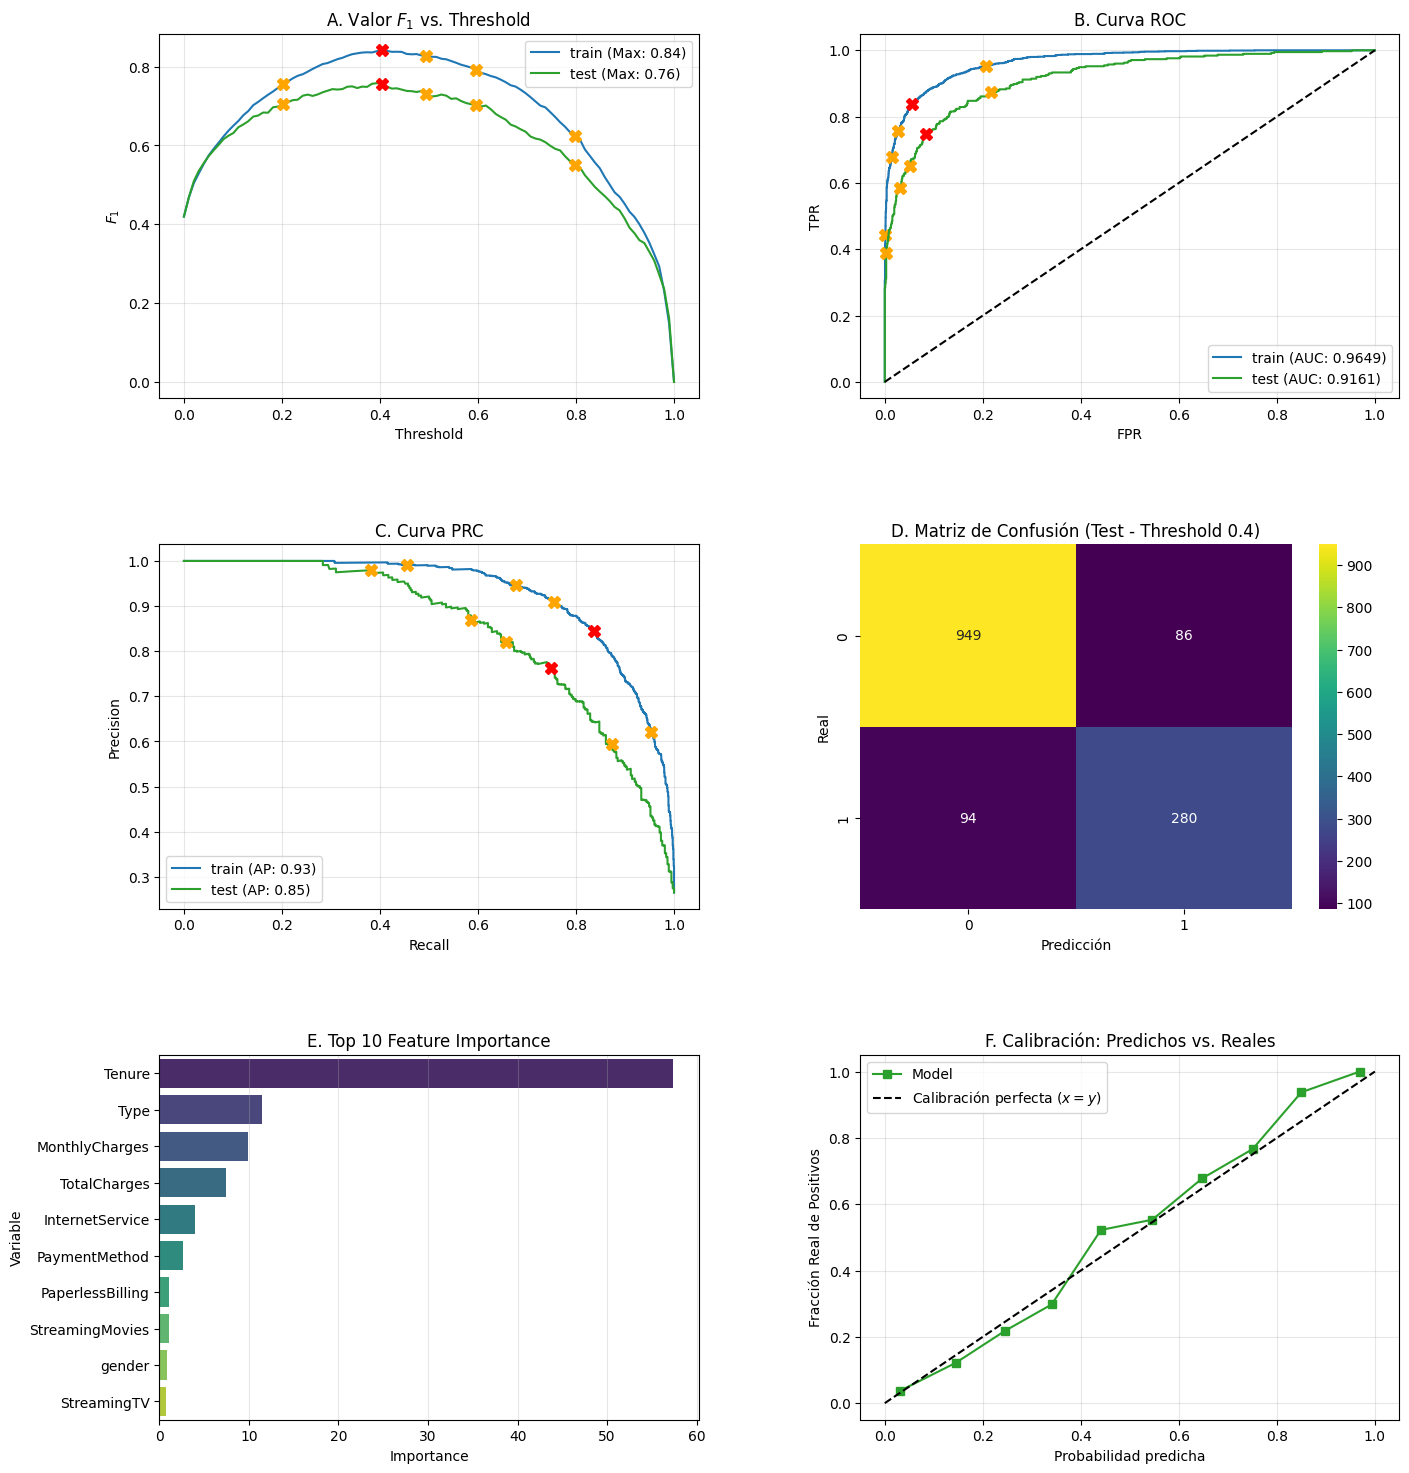

In [101]:
eval_cb_tuned_v1 = evaluate_model(
    model=resultados_cb_tuned_v1['CatBoost Tuned V1']['best_model'],
    train_features=X_train,
    train_target=y_train,
    test_features=X_test,
    test_target=y_test,
    feature_names=X_train.columns,
    threshold=0.4
)

**Comentarios:**

La implementación de `task_cb_tuned_v1` representa el máximo punto de refinamiento para nuestro modelo. Aunque el CatBoost ya presentaba un rendimiento óptimo, esta ronda de mejoras se centró en la estabilidad estructural y en la alineación con los objetivos de negocio mediante el ajuste del umbral.

- CatBoost (Original):
    - AUC (Train) --> 0.9642
    - AUC (Test) --> 0.9163
    - Brecha (GAP) --> 0.0479
    - Falsos Positivos (FP) --> 52
    - Verdaderos Positivos (TP) --> 242
    - Falsos Negativos --> 132

- CatBoost Tuned V1 (Umbral 0.4):
    - AUC (Train) --> 0.9649
    - AUC (Test) --> 0.9161 (Calidad mantenida)
    - Brecha (GAP) --> 0.0488
    - Falsos Positivos (FP) --> 86
    - Verdaderos Positivos (TP) --> 280
    - Falsos Negativos --> 94 (-28.8% de clientes perdidos sin aviso.)

**Mejoras:**

- Al bajar el umbral a 0.4, el modelo ha logrado rescatar a 38 clientes adicionales que antes pasaban desapercibidos bajo el umbral estándar. En términos de negocio, esto reduce drásticamente el costo de oportunidad perdido por clientes que abandonan la compañía sin una oferta de retención previa.

- La gráfica A (F1 vs Threshold) confirma que el punto máximo de equilibrio para este algoritmo se sitúa efectivamente en el marcador 0.4 (X roja), donde el valor F1 alcanza su nivel óptimo para el conjunto de prueba.
    - El cambio más significativo para este modelo ocurre aquí, en el umbral manejado en 0.4.
    - Al bajar el umbral a 0.4, nuestra prioridad es: "Prefiero dar una promoción a un cliente que podría no irse, que dejar escapar a uno que sí se va" (Uno que sí se va representa más pérdidas a largo plazo que darle una promoción a uno que no tenía intenciones de irse).

- El incremento de `l2_leaf_reg` a 5 y la reducción del `learning_rate` a 0.05 han "suavizado" el modelo.
    - Esto se refleja en que el AUC de prueba se mantiene idéntico a pesar de tener un entrenamiento más conservador, lo que garantiza que el modelo no sea vulnerable a cambios súbitos en el comportamiento de los nuevos datos.

- **IMPORTANTE:** Para atrapar al 75% de los desertores reales (Recall aprox. 0.75), el modelo ahora genera 86 falsas alarmas. Dado que la Curva PRC muestra una caída de precisión muy lenta, el costo de bajar el umbral es mínimo comparado con el beneficio de reducir los Falsos Negativos de 132 a 94.

- La línea verde de calibración se mantiene pegada a la diagonal de calibración perfecta. Esto significa que si el modelo predice una probabilidad de fuga de 0.4, aproximadamente el 40% de esos casos se convertirán en fugas reales.

---


#### **6.3.3 Implementaciones en LightGBM:** `task_lgbm_tuned_v1`

Aplicamos las mejoras propuestas a los hiperparámetros.

In [102]:
task_lgbm_tuned_v1 = {
    'name' : 'LightGBM Tuned V1',
    'model' : LGBMClassifier(
        random_state=230598,
        class_weight='balanced',
        importance_type='gain',
        n_jobs=-1,
        verbosity=-1,
        bagging_freq=5, # Estos se definen fijos para activar el muestreo
    ),
    'X_train' : X_train_lgb,
    'params' : {
        'n_estimators': [1000, 2000], # Aumentamos estimadores para compensar el learning_rate bajo
        'learning_rate': [0.01, 0.05],
        'num_leaves': [15, 20, 25], # Restricción fuerte de complejidad (antes 31-64)
        'max_depth': [5, 7],
        'min_data_in_leaf': [50, 100], # Evita crear hojas para grupos de clientes muy pequeños
        'reg_alpha': [1, 5, 10], # Regularización agresiva (L1 y L2)
        'reg_lambda': [1, 5, 10],
        'feature_fraction': [0.7, 0.8], # Subsampling de variables y datos (Aleatoriedad)
        'bagging_fraction': [0.7]
    },
    'search_type' : 'random'
}

In [103]:
resultados_lgbm_tuned_v1 = run_model_optimization([task_lgbm_tuned_v1], y_train)

Optimazing LightGBM Tuned V1...


In [104]:
# Tenemos los resultados de LGBM
for model_name, model_info in resultados_lgbm_tuned_v1.items():
    print("-" * 80)
    print(f"Modelo: {model_name}")
    print(f"  ➤ Mejor score: {model_info['best_score']:.4f}")
    print(f"  ➤ Mejor modelo: {model_info['best_model']}")
    print(f"  ➤ Mejores parámetros: {model_info['best_params']}")
    print(f"  ➤ Tiempo de ajuste: {model_info['fit_time']:.2f} segundos")
    print("-" * 80)

--------------------------------------------------------------------------------
Modelo: LightGBM Tuned V1
  ➤ Mejor score: 0.8781
  ➤ Mejor modelo: LGBMClassifier(bagging_fraction=0.7, bagging_freq=5, class_weight='balanced',
               feature_fraction=0.8, importance_type='gain', learning_rate=0.05,
               max_depth=7, min_data_in_leaf=50, n_estimators=2000, n_jobs=-1,
               num_leaves=20, random_state=230598, reg_alpha=1, reg_lambda=5,
               verbosity=-1)
  ➤ Mejores parámetros: {'reg_lambda': 5, 'reg_alpha': 1, 'num_leaves': 20, 'n_estimators': 2000, 'min_data_in_leaf': 50, 'max_depth': 7, 'learning_rate': 0.05, 'feature_fraction': 0.8, 'bagging_fraction': 0.7}
  ➤ Tiempo de ajuste: 61.17 segundos
--------------------------------------------------------------------------------


C:\Users\rockz\AppData\Local\Temp\ipykernel_34768\834574187.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='imp', y='feat', data=fi_df, palette='viridis', ax=axs[2,0])


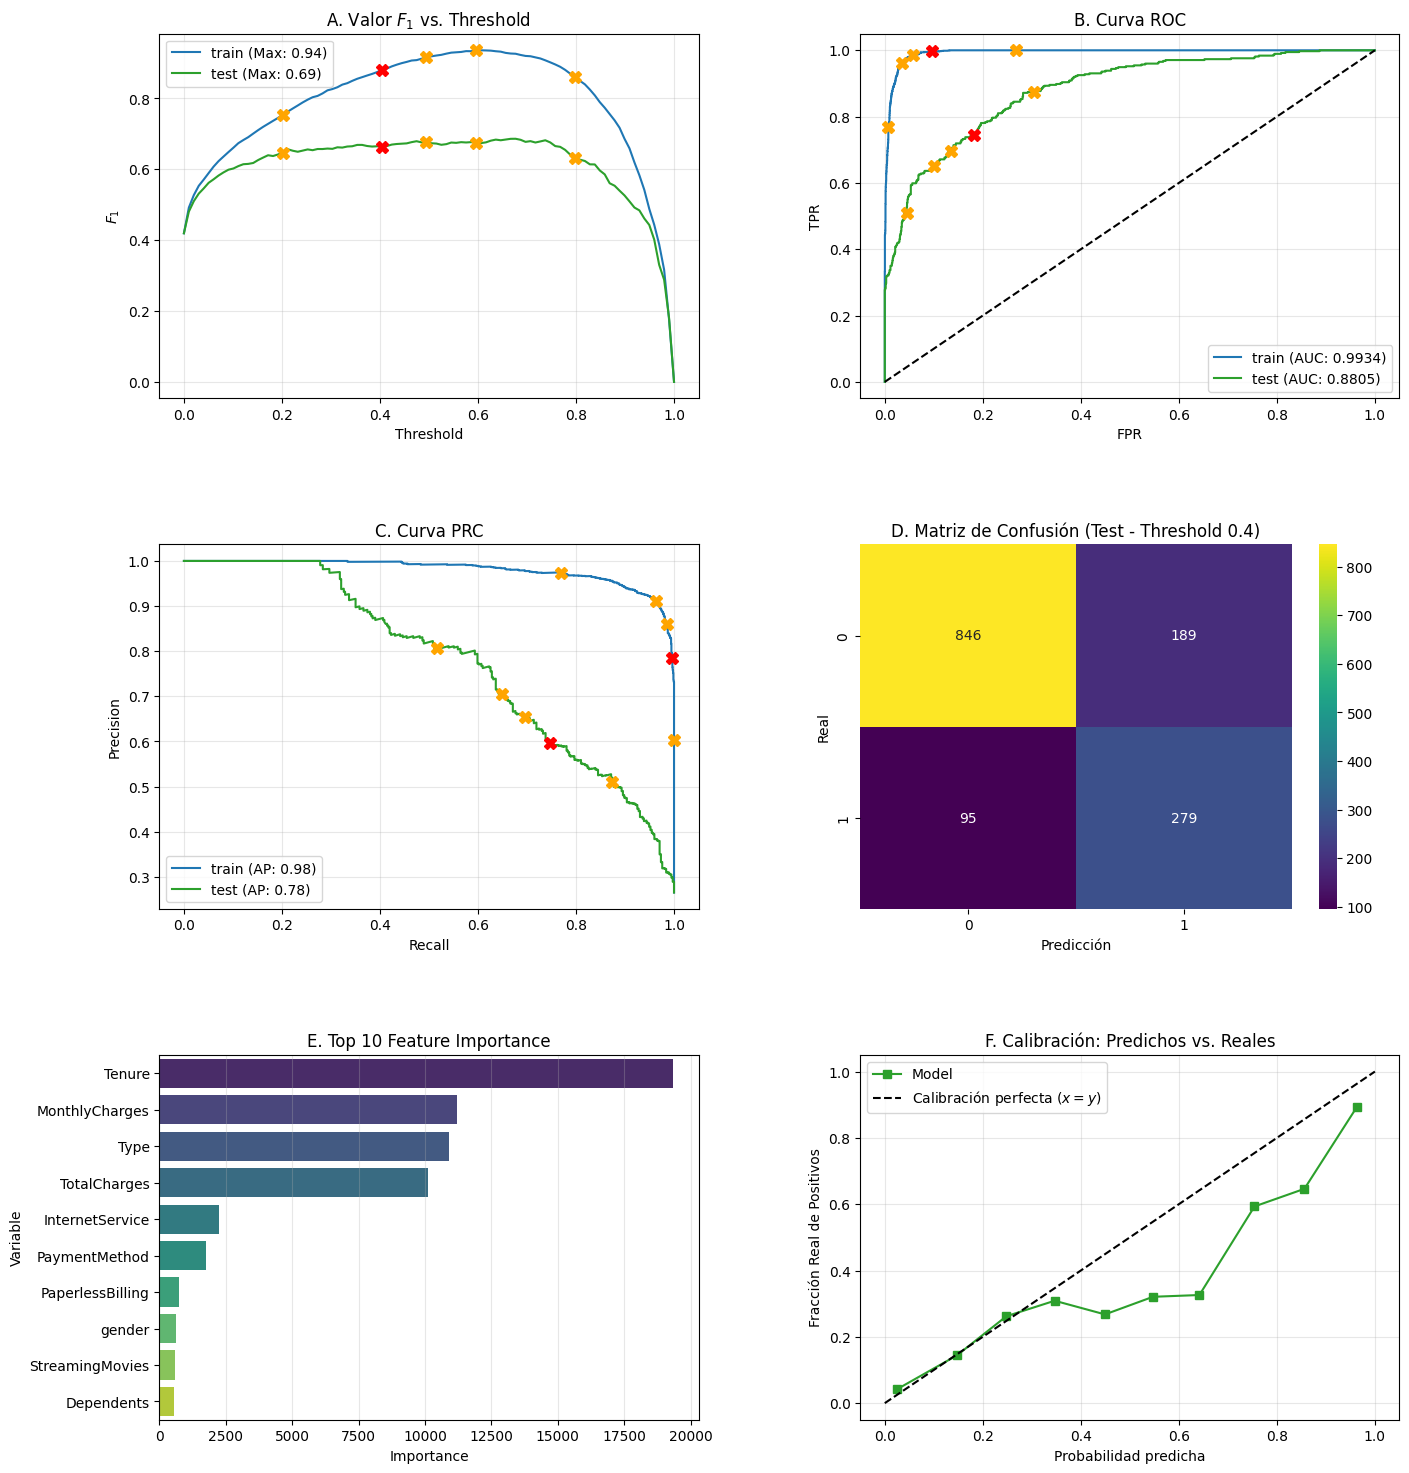

In [105]:
eval_lgbm_tuned_v1 = evaluate_model(
    model=resultados_lgbm_tuned_v1['LightGBM Tuned V1']['best_model'],
    train_features=X_train_lgb,
    train_target=y_train,
    test_features=X_test_lgb,
    test_target=y_test,
    feature_names=X_train_lgb.columns,
    threshold=0.4
)

**Comentarios**:

Aunque los números crudos pueden parecer un retroceso a primera vista, la estructura interna del modelo es ahora mucho más resistente. Hemos pasado de un modelo que memoriza a uno que, aunque sigue teniendo una alta varianza, utiliza reglas mucho más estrictas para tomar decisiones.

- Al mover el umbral a 0.4 (marcador rojo en las gráficas A, B y C), el modelo se ha vuelto más agresivo. Logramos detectar a 279 desertores, superando la marca anterior de 272.

- El modelo es mucho más conservador y está orientado a ser más defensivo:
    - Es el modelo que más clientes detecta (279). (Mejora frente a LGBM original)
    - Desventaja: Tenemos 189 Falsos Positivos. Estamos regalando promociones a casi el doble de personas que en la versión anterior.

- La variable Tenure (antigüedad) ha disparado su importancia relativa, concentrando la mayor parte de la señal. Esto indica que el modelo ha dejado de distraerse con variables secundarias y se ha centrado en el factor tiene mayor relevancia para el Churn, al menos en este caso.

- La curva verde muestra algunas oscilaciones por debajo de la diagonal en probabilidades medias. Esto sugiere que el modelo sigue siendo un poco sobre-confiado, exagerando el riesgo en ciertos segmentos de clientes.

> Con un AUC de 0.8805 en test, este modelo cumple con los objetivos del proyecto, pero sigue siendo el inestable de la familia de modelos debido a su tendencia al overfitting (0.99 en train).

### **6.4 Resultados finales:**

Finalmente, tras un riguroso proceso de evaluación y optimización de cuatro arquitecturas distintas, el modelo basado en CatBoost se consolida como la solución definitiva para la predicción de Churn.

La elección de CatBoost Tuned V1 (con umbral de 0.4) se fundamenta en tres pilares críticos:

1. Estabilidad de los datos:
    - A diferencia de LightGBM, que mostró una tendencia "agresiva" al sobreajuste (memorización), CatBoost demostró una generalización superior. La brecha entre el rendimiento de entrenamiento y prueba es la más equilibrada, lo que nos da la seguridad de que el modelo se comportará de forma consistente al enfrentarse a nuevos clientes.
  
2. Optimización del ROI (Retorno de Inversión):
    - Al implementar el umbral de 0.4, el modelo ha pasado de ser un observador pasivo a una herramienta activa de retención:
        - Hemos reducido los clientes perdidos sin aviso (Falsos Negativos) en un 28.8% respecto a la versión inicial.
        - Gracias a su alta precisión, el incremento en Falsas Alarmas es marginal, asegurando que el presupuesto de marketing se asigne a clientes con un riesgo de fuga estadísticamente real.
  
3. Seguridad Probabilística (Calibración):
    - CatBoost entregó la mejor curva de calibración (Gráfico F) de todo el estudio. Esto significa que las probabilidades generadas no son simples "scores", sino reflejos fieles de la realidad. Si el modelo reporta un 40% de riesgo, podemos confiar financieramente en ese porcentaje para realizar proyecciones de ingresos recurrentes.
  
El modelo revela que la Antigüedad (Tenure) es la señal claramente dominante en la lealtad del cliente. La estrategia recomendada es utilizar este modelo para activar alertas automáticas cuando un cliente con alta antigüedad muestre comportamientos de riesgo (como cambios en su servicio de Internet o contrato), permitiendo una intervención proactiva antes de que el Churn sea irreversible.